# **Heart Stroke Prediction**

Stroke Prediction -
Stroke is a severe medical condition caused by a disruption in blood supply to the brain, resulting from either a blockage or the rupture of a blood vessel. Prompt medical attention is crucial in such cases. Numerous factors contribute to an increased risk of stroke, making it essential to explore the relationships between these factors and the occurrence of stroke. Analyzing a dataset containing information such as age, gender, hypertension, heart disease, average glucose level, smoking status, and BMI enables the training of machine learning models. These models can identify patterns and make predictions about an individual's likelihood of experiencing a stroke. Integrating such predictive models into healthcare systems allows medical professionals to proactively identify individuals at higher risk of stroke, enabling preventive measures and better management of the condition. This approach has the potential to save lives and enhance patient outcomes.

Goal here is to classify whether a person has a stroke or not. That is, it is a classification problem.

The information about dataset:

- id: unique identifier

- gender: "Male", "Female" or "Other"

- age: age of the patient

- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

- ever_married: "No" or "Yes"

- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

- Residence_type: "Rural" or "Urban"

- avg_glucose_level: average glucose level in blood

- bmi: body mass index

- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"

- stroke: 1 if the patient had a stroke or 0 if not

Models used -
- Logistic Regression
- XGBoost
- AutoML

SHAP Analysis -

SHAP (SHapley Additive exPlanations) analysis is a method used to explain the output of machine learning models. It provides insights into how the input features contribute to the model's predictions.

SHAP values provide a clear interpretation of feature importance by quantifying the impact of each feature on the model's output. This helps to understand which features are driving the model's predictions and how they influence them.

## Installing Libraries

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.4 MB/s eta 0:00:00


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.0 MB/s eta 0:00:00


## Importing Libraries

In [3]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import logging
import csv
import time
import psutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import shap

## Reading the data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/pranitee23/Data-Science-Methods-and-Tools/main/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# checking null values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- This dataset has 5 categorical columns and 7 numerical columns.
- Here, the target variable is "stroke" and all other are the independent variables. Therefore, "bmi" is one of the independent variables that has 201 null values.

In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- In the age column, the range is 0.08 to 82 and the mean age being 43.22. Here the min age can be a data entry issue or can be related to infants. The range of all the other variables make sense.
- For example -
- Gender ranges from 0 to 2, that is male, female, and other
Ever Married ranges from 0 to 1, that is yes or no. Same goes with hypertension, heart disease, and stroke.
- Smoking Status ranges from 0 to 3. These include formerly smoked, never smoked, smokes and unknown.
- Residence type ranges from 0 to 1 that is rural  or urban.
Work Type ranges from 0 to 4. These include Private, self employed, Govt job, Children, and never worked.

In [7]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


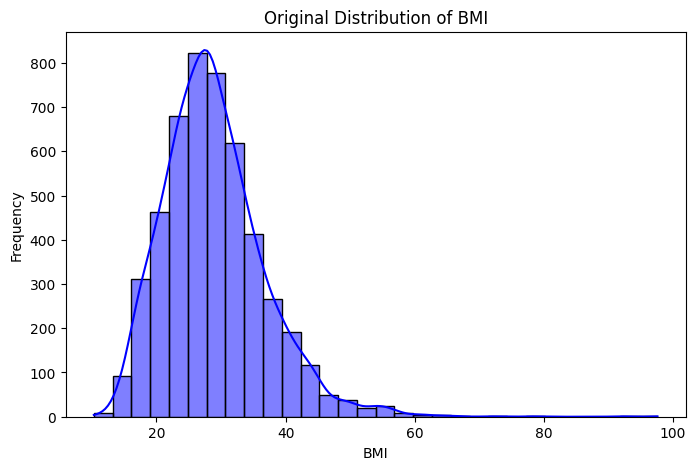

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df['bmi'], kde=True, bins=30, color='blue')
# taking the bmi column since it has null values to see its destributions
plt.title('Original Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

BMI column has 201 null values. The graph above tells that the bmi has right-skewed distribution. Therefore using median to impute the missing values later.

## Preprocessing - Dropping ID and imputing null values from bmi with median

In [10]:
# dropping the id column
df.drop('id' , axis = 1 , inplace = True)

#filling the null values by median
df.bmi.fillna(df.bmi.median(),inplace=True)
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

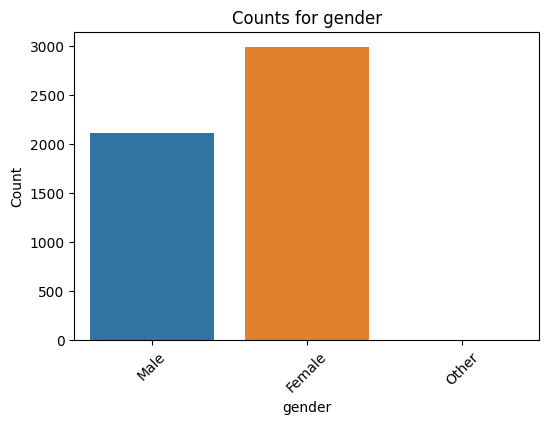

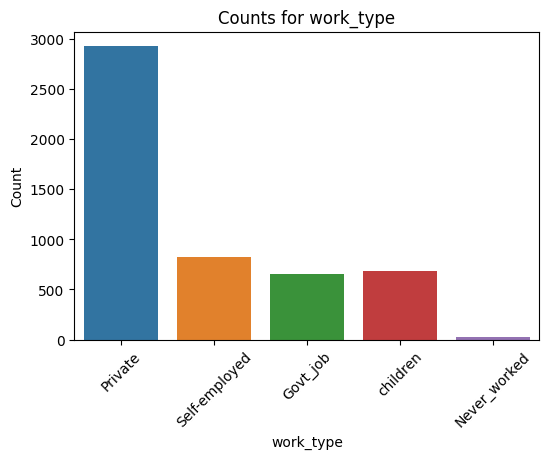

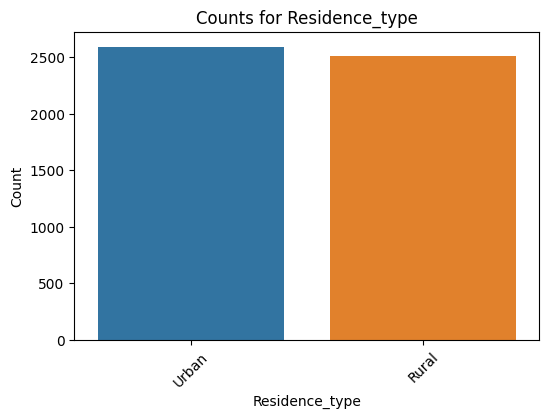

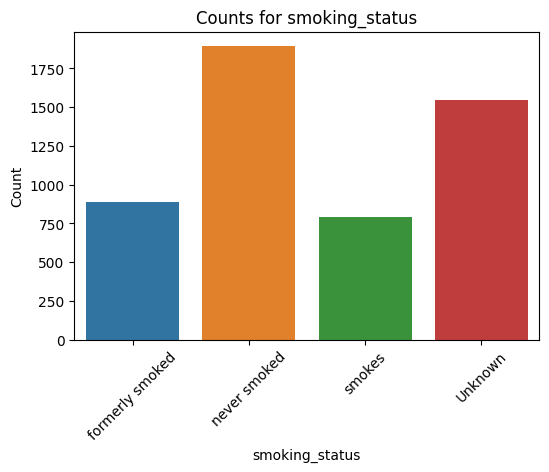

In [11]:
# List of categorical columns
categorical_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status']

# Loop through each categorical column
for column in categorical_columns:
    # Create a new figure for each column
    plt.figure(figsize=(6, 4))

    # Plot the count for the current column
    sns.countplot(x=df[column], hue= df[column])

    # Set labels and title
    plt.title(f"Counts for {column}")
    plt.ylabel("Count")
    plt.xlabel(column)
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

From these graphs we see the distributions of various unique values of each features that are present

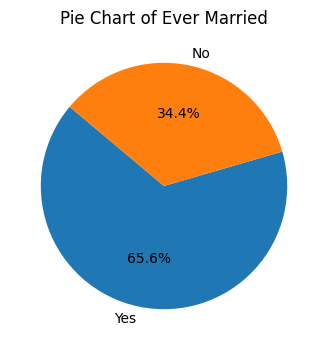

In [12]:
ever_married_counts = df['ever_married'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(ever_married_counts, labels=ever_married_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Ever Married')
plt.show()

From this graph, it is seen that 65.6% of the individuals are married and 34.4% are not.

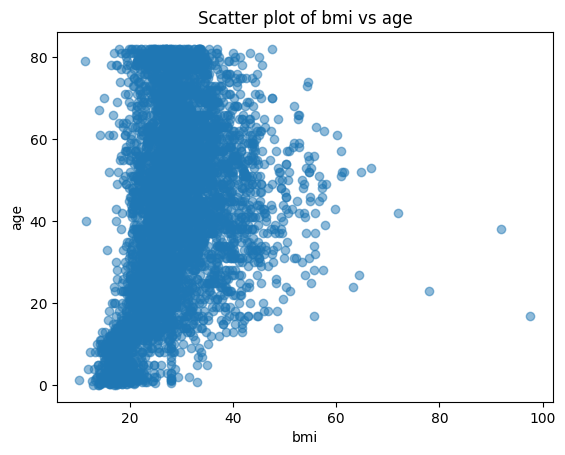

In [13]:
plt.scatter(df['bmi'], df['age'], alpha=0.5)
plt.title('Scatter plot of bmi vs age')
plt.xlabel('bmi')
plt.ylabel('age')
plt.show()

- Density of Data Points: There's a high density of points along the lower BMI values, which suggests that a large number of individuals in the dataset have BMI values in the lower range.

- Age Distribution: The ages are fairly uniformly distributed across the BMI range, with  a slight concentration of younger individuals at lower BMI values.

- Outliers: There appear to be some outliers, especially in terms of BMI, with a few points having significantly higher BMI values compared to the rest of the data.

- Potential Relationship: The plot doesn't suggest a clear or strong relationship between age and BMI; the points are quite spread out across ages for any given BMI. This could indicate that within this dataset, BMI does not change significantly with age, or that any relationship is not linear and might require more complex modeling to understand.

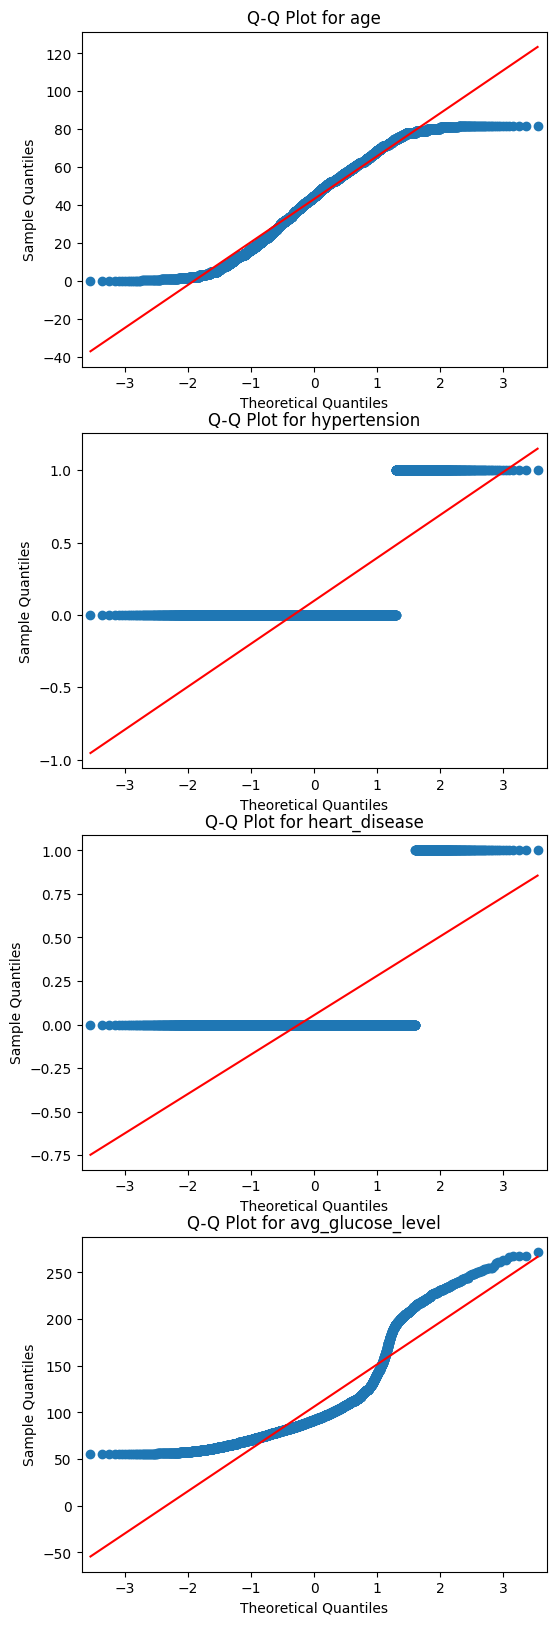

In [14]:
numeric_columns_list = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level'] # creating a list

fig, axes = plt.subplots(nrows=len(numeric_columns_list), figsize=(6, 5 * len(numeric_columns_list)))

# Plot Q-Q plots for each numeric variable
for i, variable in enumerate(numeric_columns_list):
    sm.qqplot(df[variable], line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot for {variable}')

plt.show()

qq plot is drawn for all the numeric columns:
- For age column, some of the datapoints align with the therotical values. All the values in age are continuous in nature
- For hypertension, heart disease, and stroke, values are binomial. It is either yes/no or 1/0.
- For bmi column there are values in the middle quartile which obey the theoritical values, and other values deviate from the standard line. This shows that there are more extreme values (both low and high) than what would be expected in a normal distribution
- For avg_glucose_level there are values which deviate from the straight line, showing that there are extreme values than what would be expected in a normal distribution.

## Label Encoding

In [15]:
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

'''
Gender - Female(0), Male(1)
work_type - Private(2), self_employed(3), children(4), Govt_job(0), never_worked(1)
Residence_type - Urban(1), Rural(0)
smoking_status - never smoked(2), unknown(0), formerly smoked(1), smokes(3)
ever_married - Yes(1), No(0)
'''

'\nGender - Female(0), Male(1)\nwork_type - Private(2), self_employed(3), children(4), Govt_job(0), never_worked(1)\nResidence_type - Urban(1), Rural(0)\nsmoking_status - never smoked(2), unknown(0), formerly smoked(1), smokes(3)\never_married - Yes(1), No(0)\n'

### Histograms

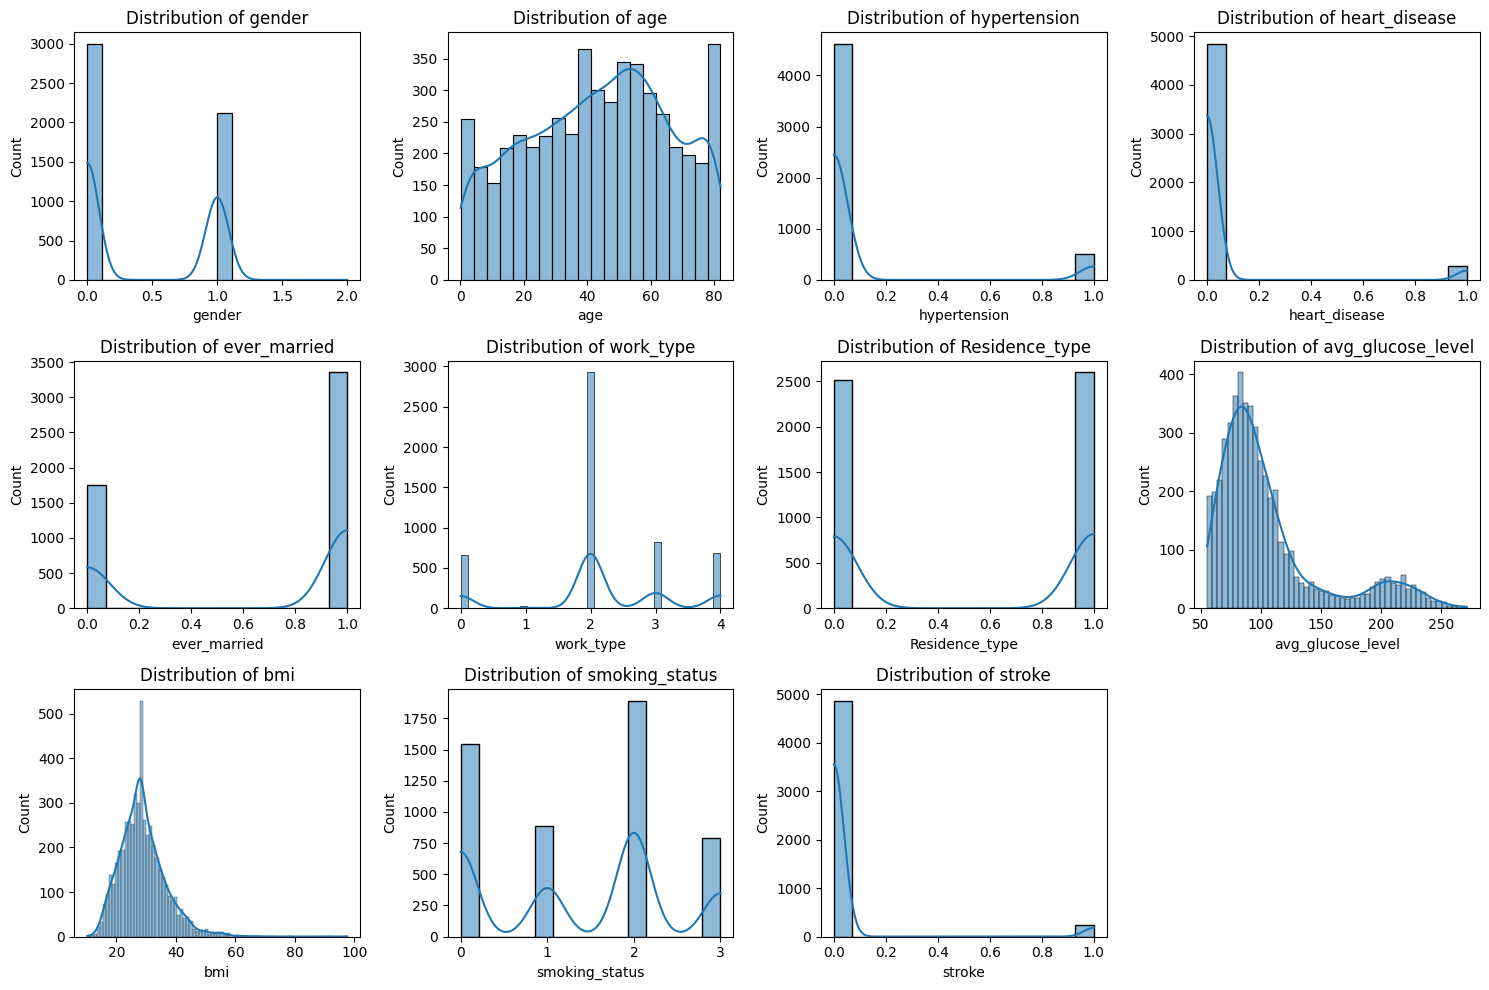

In [16]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Distribution of Gender:
This histogram shows the frequency of each gender category in the dataset. The x-axis represents gender categories, which are probably encoded as numerical values, and the y-axis represents the count of observations in each category.

- Distribution of Age:
This plot shows the age distribution of individuals in the dataset. The x-axis is the age in years, and the y-axis is the count of individuals. It looks like a unimodal distribution, with the majority of individuals in the middle age range.

- Distribution of Average Glucose Level:
The last plot shows the distribution of average glucose levels among individuals. The x-axis is the average glucose level, and the y-axis is the count of individuals. It appears to have a right-skewed distribution, with most individuals having glucose levels in the lower range and fewer individuals having very high glucose levels.

- Distribution of Heart Disease:
Similar to the hypertension histogram, this one shows the count of individuals with and without heart disease, which is another binary feature.

- Distribution of Ever Married:
This histogram shows the marital status of individuals, with categories likely encoded as 0 for 'No' and 1 for 'Yes', indicating whether individuals have ever been married.

## Heatmaps to show the correlation between the dependent and independent variable

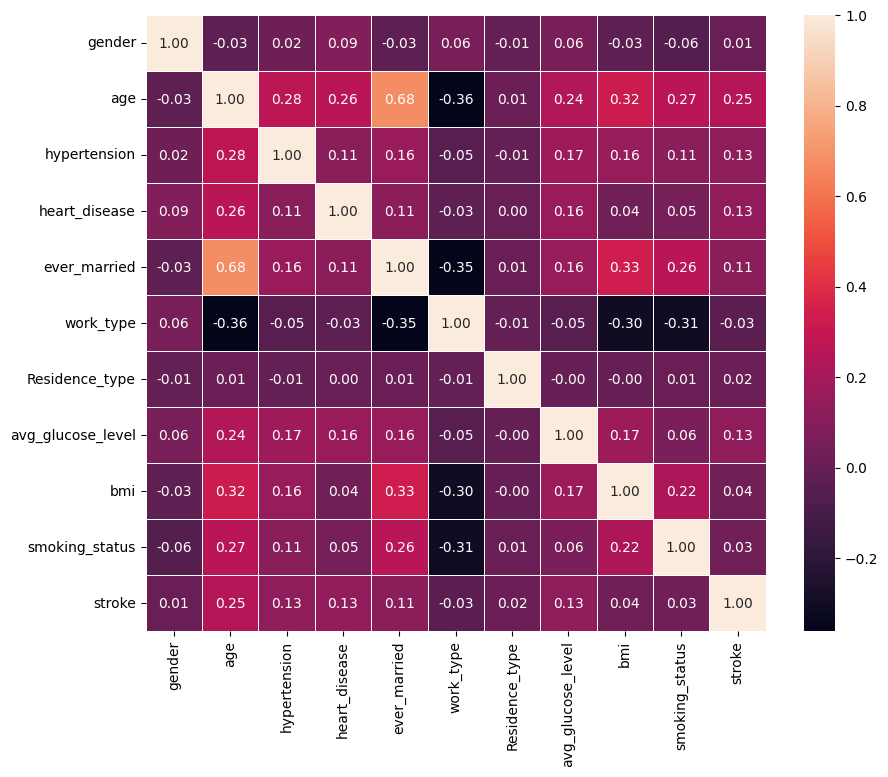

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,linewidths=.5,fmt='.2f')
plt.show()

From the predictor variables, according to the heatmap, age and ever_married have a positive correlation of 0.68 value.

## Handling Outliers

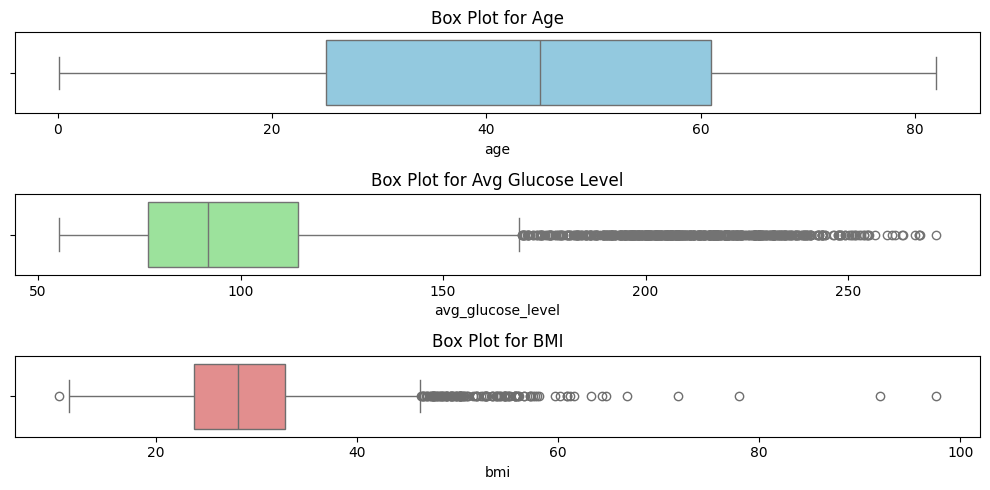

In [ ]:
# Box plot
plt.figure(figsize=(10, 5))

# Box plot for 'age'
plt.subplot(3, 1, 1)
sns.boxplot(x=df['age'], color='skyblue')
plt.title('Box Plot for Age')

# Box plot for 'avg_glucose_level'
plt.subplot(3, 1, 2)
sns.boxplot(x=df['avg_glucose_level'], color='lightgreen')
plt.title('Box Plot for Avg Glucose Level')

# Box plot for 'bmi'
plt.subplot(3, 1, 3)
sns.boxplot(x=df['bmi'], color='lightcoral')
plt.title('Box Plot for BMI')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Identifying outliers using IQR method for 'avg_glucose_level'
Q1_glucose = df['avg_glucose_level'].quantile(0.25)
Q3_glucose = df['avg_glucose_level'].quantile(0.75)
IQR_glucose = Q3_glucose - Q1_glucose
lower_bound_glucose = Q1_glucose - 1.5 * IQR_glucose
upper_bound_glucose = Q3_glucose + 1.5 * IQR_glucose

# Finding outliers in 'avg_glucose_level'
outliers_glucose = df[(df['avg_glucose_level'] < lower_bound_glucose) | (df['avg_glucose_level'] > upper_bound_glucose)]

# Removing 'bmi' outliers
stroke_data_no_outliers_glucose = df.drop(outliers_glucose.index)

# Store the lower bound, upper bound, and number of outliers removed for 'avg_glucose_level'
threshold_comparison_glucose = pd.DataFrame({
    'Column': ['avg_glucose_level'],
    'Lower Bound': [lower_bound_glucose],
    'Upper Bound': [upper_bound_glucose],
    'Outliers Removed': [len(outliers_glucose)]
})
print(threshold_comparison_glucose)

              Column  Lower Bound  Upper Bound  Outliers Removed
0  avg_glucose_level      21.9775     169.3575               627


In [ ]:
X_outlier_glucose = stroke_data_no_outliers_glucose.drop('stroke', axis=1)
y_outlier_glucose = stroke_data_no_outliers_glucose['stroke']

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_outlier_glucose, y_outlier_glucose, test_size=0.3, random_state=42,shuffle=True)

In [ ]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3546,0,7.0,0,0,0,4,1,98.22,34.0,0
4791,0,64.0,0,0,1,2,1,65.63,33.5,3
260,1,79.0,0,1,1,2,1,57.08,22.0,1
4299,0,66.0,0,0,1,3,0,85.90,34.6,2
448,1,65.0,0,0,1,2,1,145.15,28.9,0


## Logistic Regression Model

In [ ]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

# Accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")

Logistic Regression Accuracy: 0.9621


### Interpreting Regression Coefficients

In [ ]:
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': logreg_model.coef_[0]})
print(coefficients)

            Variable  Coefficient
0             gender     0.268469
1                age     0.077120
2       hypertension     0.338717
3      heart_disease    -0.066414
4       ever_married    -0.446171
5          work_type    -0.076684
6     Residence_type     0.070040
7  avg_glucose_level     0.000182
8                bmi    -0.024623
9     smoking_status    -0.122931


- Gender: The coefficient for gender is positive (0.268469), indicating that males (encoded as 1) have a higher log-odds of having a stroke compared to females (encoded as 0), holding other variables constant.

- Age: The positive coefficient (0.077120) for age suggests that as age increases, the log-odds of having a stroke increase, which is consistent with medical knowledge that stroke risk typically increases with age.

- Ever Married: The negative coefficient (-0.446171) for being ever married (encoded as 1) suggests that married individuals have lower log-odds of having a stroke compared to those who have never been married (encoded as 0). This might reflect the possible health benefits of marriage, such as social support.

- Work Type: The negative coefficient for work type (-0.076684) suggests that with an increase in the encoded value for work type, the log-odds of having a stroke decrease. Given your encoding, individuals who have 'never worked' (encoded as 1) have a lower risk compared to those with 'private' jobs (encoded as 2), and so on.

- Smoking Status: The negative coefficient (-0.122931) implies that as the encoded value for smoking status increases, the log-odds of having a stroke decrease. With your encoding, 'smokes' (encoded as 3) would be associated with a lower log-odds compared to 'formerly smoked' (encoded as 1), which might suggest that current smokers have a lower risk than former smokers, but such a conclusion could be misleading without further context and understanding of the data.

- BMI: The negative coefficient (-0.024623) for BMI suggests that a higher BMI is associated with lower log-odds of having a stroke, which is contrary to common health perspectives where high BMI is a risk factor for stroke.

- Residence Type: The coefficient (0.070040) for residence type is positive, which indicates that individuals living in urban areas (encoded as 1) have higher log-odds of having a stroke compared to those living in rural areas (encoded as 0)

### Confusion Matrix - Logistic Regression

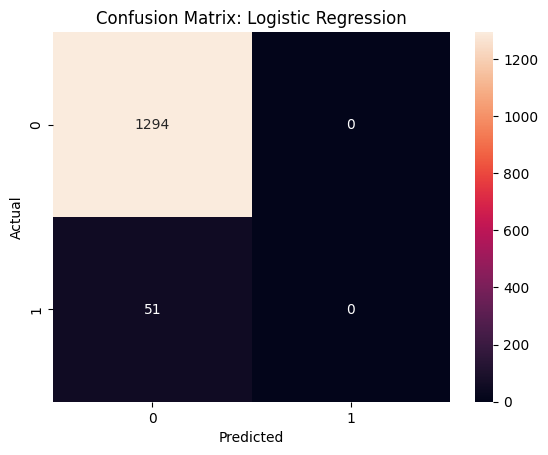

In [ ]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt="d")
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Classification Report - Logistice Regression

In [ ]:
# Classification Report Logistic Regression
classification_rep_logreg = classification_report(y_test, y_pred_logreg, zero_division=1)

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_rep_logreg)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1294
           1       1.00      0.00      0.00        51

    accuracy                           0.96      1345
   macro avg       0.98      0.50      0.49      1345
weighted avg       0.96      0.96      0.94      1345



## SHAP Analysis on Logistic Regression Model

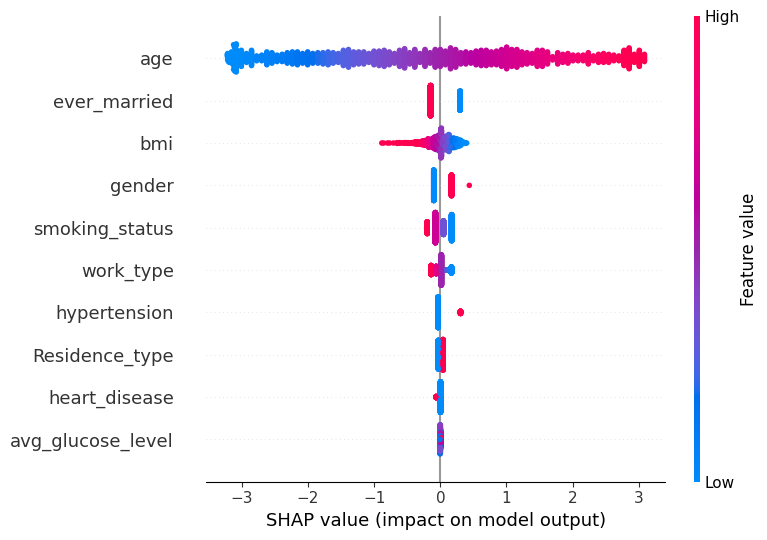

In [ ]:
explainer = shap.LinearExplainer(logreg_model, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

- Age is the most impactful feature, with higher values pushing predictions towards higher likelihoods of stroke.
- Being ever married (presumably being married is the high feature value indicated by red) seems to lower the likelihood of stroke, which is represented by the points mainly being on the left (blue).
- Higher BMI values (in red) seem to have a mix of positive and negative impacts on the stroke prediction, with a spread across both sides of zero.
- Gender (with male as 1) has a noticeable impact, with being male (in red) contributing to a higher prediction of stroke.
- Smoking status, work type, hypertension, residence type, heart disease, and average glucose level also contribute to the model's output, but their impact is less pronounced compared to age, marital status, and BMI.

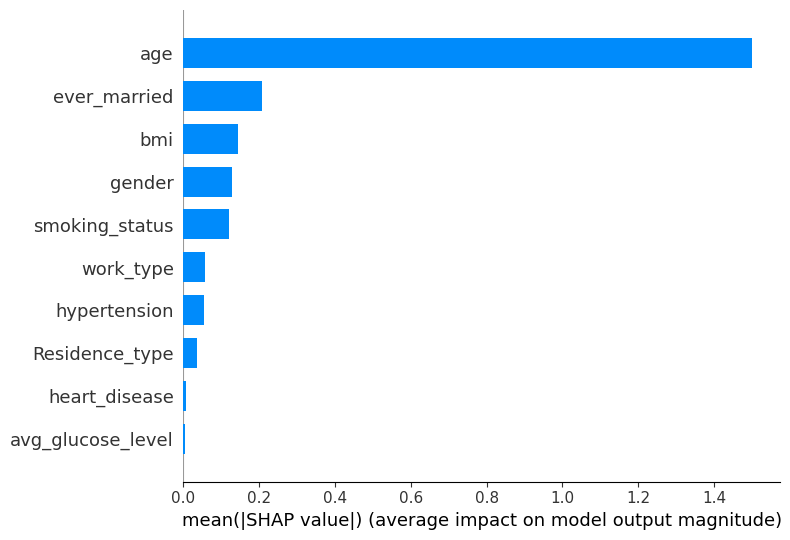

In [ ]:
explainer = shap.Explainer(logreg_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

- Age has the largest average impact on the model's output, which means that changes in age are, on average, the most influential in affecting the model's predictions.
- The features following age in descending order of impact are ever married, BMI, gender, smoking status, work type, hypertension, and residence type.
- Heart disease and average glucose level have the least average impact on the model's output.

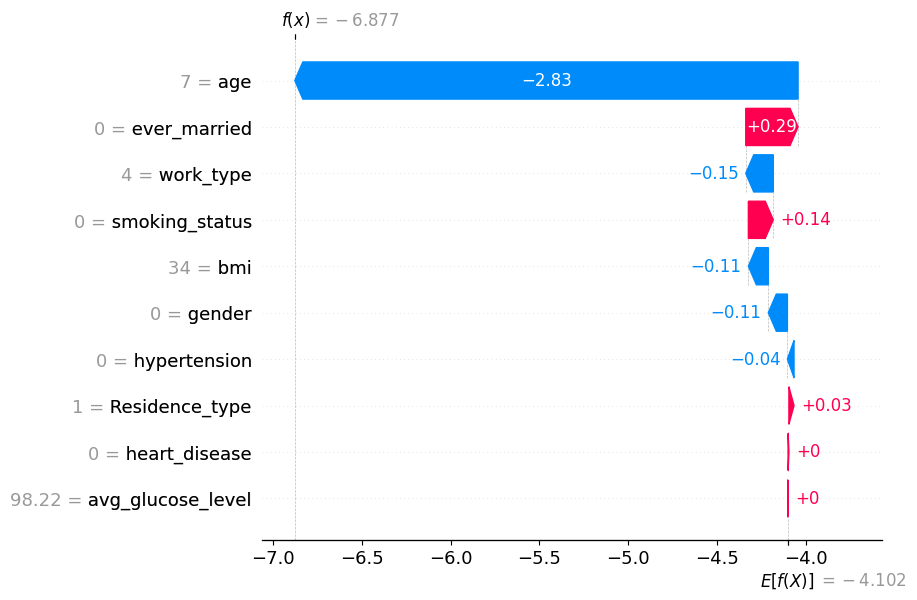

In [ ]:
explainer = shap.Explainer(logreg_model, X_train)

# Calculate SHAP values for a single instance
shap_values = explainer(X_train.iloc[[sample_ind]])

# Generate the SHAP waterfall plot for the selected instance
shap.plots.waterfall(shap_values[0], max_display=14)

Each bar represents the impact of an individual feature on the model's prediction for this particular instance, relative to the base value.
Red bars represent features that push the prediction higher (increase the probability of the positive class), while blue bars push the prediction lower (decrease the probability of the positive class).

- The feature "age" appears to have a large negative impact on the model's prediction, strongly decreasing the likelihood of the positive class.
- Features like "ever_married" and "work_type" have negative contributions as well, further reducing the prediction value.
- "smoking_status" and "Residence_type" have a small positive impact, increasing the prediction value slightly.
- Many features have a contribution of zero or a negligible impact in this particular instance, as indicated by short bars or a lack of bars for those features.

## XGBOOST Model(Tree Based)

In [ ]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=4, learning_rate=0.1, n_estimators=100, seed=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


### Confusion Matrix - XGBoost

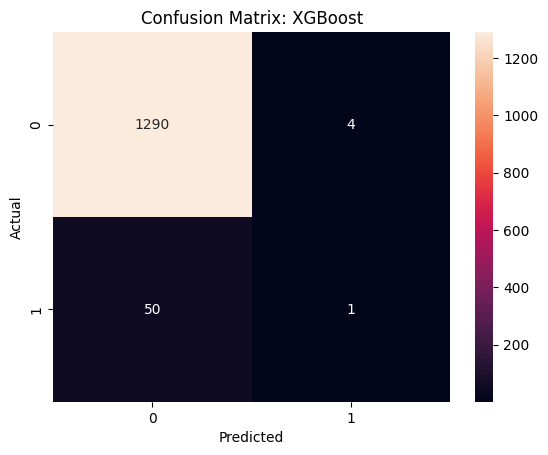

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_xgb, annot=True, fmt="d")
plt.title("Confusion Matrix: XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Classification Report

In [ ]:
# Classification Report Logistic Regression
classification_rep_xgb = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report
print("Classification Report for XGBoost:")
print(classification_rep_xgb)

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1294
           1       0.20      0.02      0.04        51

    accuracy                           0.96      1345
   macro avg       0.58      0.51      0.51      1345
weighted avg       0.93      0.96      0.94      1345



### SHAP Analysis on XGBoost

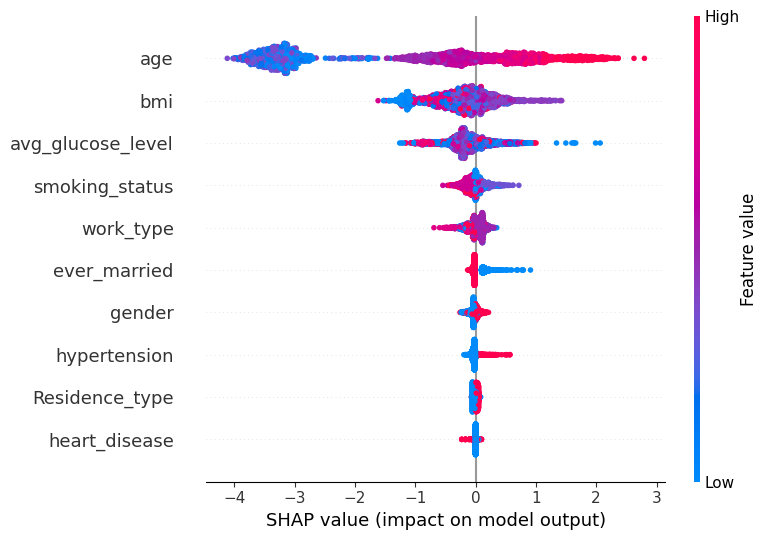

In [ ]:
explainer = shap.Explainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer(X_train)
# Summary plot
shap.summary_plot(shap_values, X_train)

In the above plot, "age" seems to have the highest importance since it's at the top. Features like "bmi" and "avg_glucose_level" also show a significant impact on the model's predictions. The color coding suggests which values of the feature (low or high) have more impact.

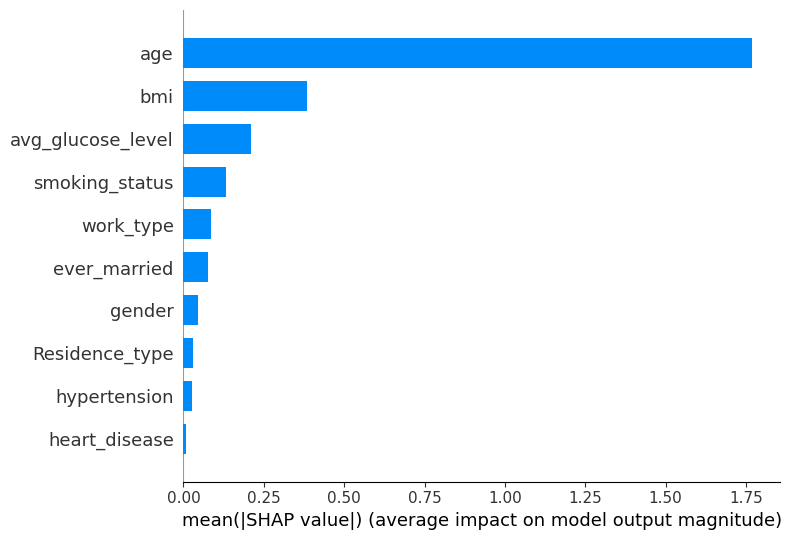

In [ ]:
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

- The x-axis represents the mean absolute SHAP value, which quantifies the average impact of a feature on the model's output magnitude. The higher the value, the more significant the feature's impact on the model prediction.
- The y-axis lists the features in descending order of importance. The most influential feature is at the top.
- 'age' appears to have the most significant average impact on model predictions, followed by 'bmi' and 'avg_glucose_level'.

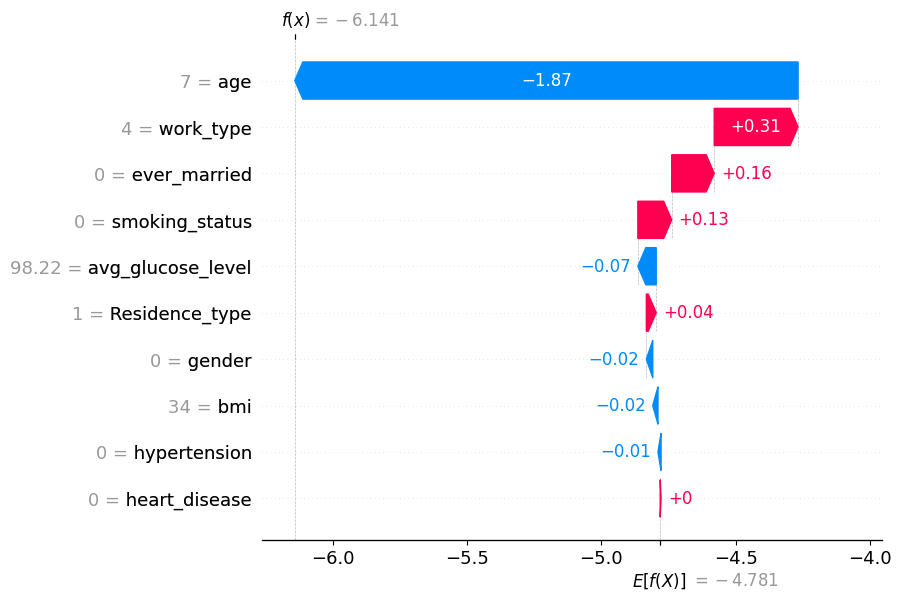

In [ ]:
# Create the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for a single instance
shap_values = explainer(X_train.iloc[[sample_ind]])

# Generate the SHAP waterfall plot for the selected instance
shap.plots.waterfall(shap_values[0], max_display=14)

- Each colored bar represents a feature's contribution towards the final prediction. Red bars indicate features that pushed the model's output higher (towards the positive class), and blue bars indicate features that pushed the output lower (towards the negative class).
- The features are listed from top to bottom by their impact on the particular prediction being explained.
- 'age' has the most significant positive contribution, while 'avg_glucose_level' has a negative contribution.

### AutoML

In [ ]:
# configure the memory allocation and the maximum runtime for the AutoML process

min_mem_size = 6
run_time = 222

In [ ]:
# related to memory size for execution

pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

5


In [ ]:
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:16764..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5x1qlmst
  JVM stdout: /tmp/tmp5x1qlmst/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5x1qlmst/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:16764
Connecting to H2O server at http://127.0.0.1:16764 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_pqsz04
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
df_h2o = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
df_h2o.describe()

Rows:5110
Cols:11

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
type,int,real,int,int,int,int,int,real,real,int,int
mins,0.0,0.08,0.0,0.0,0.0,0.0,0.0,55.12,10.3,0.0,0.0
mean,0.4142857142857141,43.226614481409,0.0974559686888454,0.05401174168297456,0.6561643835616439,2.1677103718199504,0.5080234833659492,106.14767710371815,28.86203522504894,1.3769080234833617,0.0487279843444227
maxs,2.0,82.0,1.0,1.0,1.0,4.0,1.0,271.74,97.6,3.0,1.0
sigma,0.4930436314174791,22.61264672311348,0.2966066742337912,0.22606298750336545,0.475033520037369,1.090293498184979,0.4999845441302678,45.28356015058193,7.6995623187875015,1.0715337628679502,0.2153198569802376
zeros,2994,0,4612,4834,1757,657,2514,0,0,1544,4861
missing,0,0,0,0,0,0,0,0,0,0,0
0,1.0,67.0,0.0,1.0,1.0,2.0,1.0,228.69,36.6,1.0,1.0
1,0.0,61.0,0.0,0.0,1.0,3.0,0.0,202.21,28.1,2.0,1.0
2,1.0,80.0,0.0,1.0,1.0,2.0,0.0,105.92,32.5,2.0,1.0


In [ ]:
num_rows, num_columns = df_h2o.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 5110
Number of columns: 11


### Train test split - h2o

In [ ]:
pct_rows = 0.80
df_train, df_test = df_h2o.split_frame([pct_rows])

In [ ]:
print(df_train.shape)
print(df_test.shape)

(4110, 11)
(1000, 11)


In [ ]:
X=df_h2o.columns
print(X)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [ ]:
#Seperate Dependent variable from Independent variable
y_target ='stroke'
X.remove(y_target)
print('Features except target variable: ',X)
print('Target Variable: ',y_target)

Features except target variable:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Target Variable:  stroke


In [ ]:
#set the AutoML
aml = H2OAutoML(max_runtime_secs=run_time, sort_metric='MAE',max_models=10 ,seed=1, exclude_algos=['DeepLearning'])

#pass the data through H20AutoML
aml.train(x=X,y=y_target,training_frame=df_train)

AutoML progress: |
16:08:30.360: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
16:08:35.763: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


16:08:36.396: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
16:08:38.687: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
16:08:41.654: _response param, We have d

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_3_20240317_160830


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    20                 20                          15827                  7            7            7             43            79            58.25

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03177395269633777
RMSE: 0.17825249702693585
MAE: 0.07342619036073718
RMSLE: 0.12112258747185087
Mean Residual Deviance: 0.03177395269633777

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.04405934722006302
RMSE: 0.209903185349968
MAE: 0.08556077188010866
RMSLE: 0.1473645859420195
Mean Residual Deviance: 0.04405934722006302

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0            nan           nan           nan           nan           nan
loglikelihood           nan        0            nan           nan           nan           nan           nan
mae                     0.0853881  0.00359498   0.0819208     0.0893683     0.0816305     0.0885017     0.0855189
mean_residual_deviance  0.0447491  0.000944823  0.0441692     0.0462989     0.044844      0.044575      0.0438584
mse                     0.0447491  0.000944823  0.0441692     0.0462989     0.044844      0.044575      0.0438584
r2                      0.0557367  0.019937     0.0679729     0.0230342     0.0537339     0.0594111     0.0745314
residual_deviance       0.0447491  0.000944823  0.0441692     0.0462989     0.044844      0.044575      0.0438584
rmse                    0.21153    0.00222363   0.210165      0.215172      0.211764      0.211128      0.209424
rmsle                   0.149299   0.00222716   0.148096      0.153073      0.148516      0.149392      0.14742

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-03-17 16:08:48  2.510 sec   0                  0.217694         0.094781        0.0473905
    2024-03-17 16:08:48  2.573 sec   5                  0.200799         0.0865999       0.0403203
    2024-03-17 16:08:48  2.636 sec   10                 0.191294         0.0813935       0.0365934
    2024-03-17 16:08:48  2.700 sec   15                 0.183706         0.0766221       0.0337479
    2024-03-17 16:08:48  2.758 sec   20                 0.178252         0.0734262       0.031774

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
age                122.93                 1                    0.362241
avg_glucose_level  80.9978                0.658892             0.238677
bmi                60.8113                0.49468              0.179193
smoking_status     21.2558                0.172909             0.0626348
hypertension       13.8121                0.112357             0.0407004
heart_disease      9.79573                0.0796851            0.0288652
gender             9.58753                0.0779915            0.0282517
Residence_type     8.64855                0.0703532            0.0254848
work_type          6.20277                0.0504576            0.0182778
ever_married       5.31905                0.0432688            0.0156737

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.di

### Print the best model

In [ ]:
# Get the AutoML leaderboard
leaderboard = aml.leaderboard

# Print the leaderboard
print(leaderboard)

model_id                                                       mae      rmse        mse     rmsle    mean_residual_deviance
GBM_2_AutoML_3_20240317_160830                           0.0855608  0.209903  0.0440593  0.147365                 0.0440593
GBM_3_AutoML_3_20240317_160830                           0.0858717  0.209431  0.0438614  0.14717                  0.0438614
GBM_1_AutoML_3_20240317_160830                           0.086483   0.207768  0.0431675  0.145095                 0.0431675
GBM_4_AutoML_3_20240317_160830                           0.0869611  0.210436  0.0442832  0.148101                 0.0442832
StackedEnsemble_AllModels_1_AutoML_3_20240317_160830     0.0873773  0.208095  0.0433035  0.145437                 0.0433035
StackedEnsemble_BestOfFamily_1_AutoML_3_20240317_160830  0.0889856  0.208656  0.0435374  0.145758                 0.0435374
DRF_1_AutoML_3_20240317_160830                           0.0900043  0.217159  0.0471579  0.155327                 0.0471579
XRT_1_Au

model_id,mae,rmse,mse,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_3_20240317_160830,0.0855608,0.209903,0.0440593,0.147365,0.0440593,253,0.007337,GBM
GBM_3_AutoML_3_20240317_160830,0.0858717,0.209431,0.0438614,0.14717,0.0438614,171,0.005353,GBM
XGBoost_3_AutoML_3_20240317_160830,0.0925671,0.218378,0.0476891,0.156492,0.0476891,306,0.002235,XGBoost
GLM_1_AutoML_3_20240317_160830,0.0943304,0.209447,0.0438681,0.146576,0.0438681,25,0.000636,GLM


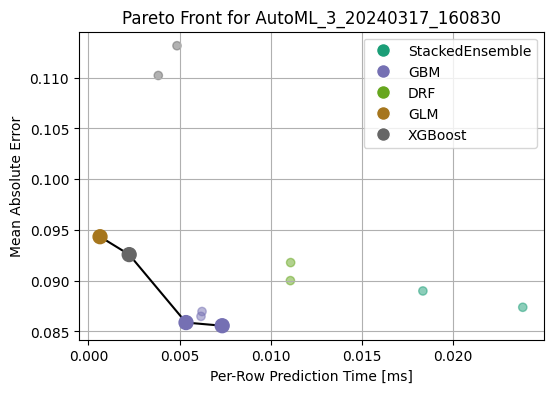

In [ ]:
pf = aml.pareto_front()
fig = pf.figure()

# Adjust the size of the figure
fig.set_size_inches(6, 4)

# Display the plot
pf

In [ ]:
best_model = aml.leader
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_3_20240317_160830


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    20                 20                          15827                  7            7            7             43            79            58.25

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03177395269633777
RMSE: 0.17825249702693585
MAE: 0.07342619036073718
RMSLE: 0.12112258747185087
Mean Residual Deviance: 0.03177395269633777

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.04405934722006302
RMSE: 0.209903185349968
MAE: 0.08556077188010866
RMSLE: 0.1473645859420195
Mean Residual Deviance: 0.0440593

In [ ]:
print("Best Model ID:", best_model.model_id)
print("Best Model MSE:", best_model.mse())

Best Model ID: GBM_2_AutoML_2_20240317_153747
Best Model MSE: 0.029474137189840034


In [ ]:
best_model.algo

'gbm'

### Train the best model

In [ ]:
best_model.train(x=X,y=y_target,training_frame=df_train)

gbm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1710688642967_25


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          16088                  5            5            5             7             31            20.88

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03090559447595005
RMSE: 0.17579987052313223
MAE: 0.07074459527453786
RMSLE: 0.12067383834179797
Mean Residual Deviance: 0.03090559447595005

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  --------------------
     2024-03-17 15:42:04  0.033 sec   0.0                0.21855177642275572  0.09552975795508734  0.047764878977542204
     2024-03-17 15:42:04  0.070 sec   1.0                0.2150904169807039   0.09394976708460398  0.04626388747693308
     2024-03-17 15:42:04  0.085 sec   2.0                0.2118115416606869   0.09235520581637123  0.0448641291806769
     2024-03-17 15:42:04  0.102 sec   3.0                0.20871981736848758  0.09079082708136783  0.0435639621623348
     2024-03-17 15:42:04  0.122 sec   4.0                0.2059161321880013   0.08927689827210887  0.04240145349526643
     2024-03-17 15:42:04  0.139 sec   5.0                0.20374316341782087  0.08800954439780576  0.04151127663950086
     2024-03-17 15:42:04  0.153 sec   6.0                0.20193082003705187  0.08688409498255696  0.04077605608083623
     2024-03-17 15:42:05  0.187 sec   7.0                0.1999404362324721   0.0857407410000291   0.039976178040831235
     2024-03-17 15:42:05  0.209 sec   8.0                0.19846761481841624  0.08481317245236016  0.03938939413171123
     2024-03-17 15:42:05  0.223 sec   9.0                0.19687367421802232  0.08382333184695703  0.038759243600103986
---  ---                  ---         ---                ---                  ---                  ---
     2024-03-17 15:42:05  0.774 sec   41.0               0.1781886747524868   0.07174735459115998  0.03175120381004752
     2024-03-17 15:42:05  0.787 sec   42.0               0.17812436339325624  0.07169634868098305  0.0317282888342528
     2024-03-17 15:42:05  0.805 sec   43.0               0.17807603577108075  0.07168909436736493  0.03171107451594323
     2024-03-17 15:42:05  0.832 sec   44.0               0.17776831916444583  0.07156537033151264  0.03160157529855228
     2024-03-17 15:42:05  0.867 sec   45.0               0.17744625256690963  0.07142780620962347  0.03148717255003949
     2024-03-17 15:42:05  0.891 sec   46.0               0.17738819721139173  0.07140035643636158  0.03146657250990761
     2024-03-17 15:42:05  0.928 sec   47.0               0.1770050517206989   0.0712206160007645   0.0313307883346473
     2024-03-17 15:42:05  0.942 sec   48.0               0.17652783281545342  0.07098608966774136  0.03116207575852067
     2024-03-17 15:42:05  0.961 sec   49.0               0.17612661666074295  0.07082433521131089  0.03102058509636029
     2024-03-17 15:42:05  0.975 sec   50.0               0.17579987052313223  0.07074459527453786  0.03090559447595005
[51 rows x 7 columns]


Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
age                135.454                1                    0.37437
avg_glucose_level  83.2077                0.614289             0.229971
bmi                78.5892                0.580192             0.217207
smoking_status     21.0076           

In [ ]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
target_column = "stroke"

# Add the actual labels to the predictions DataFrame
predictions[target_column] = df_test[target_column]

# Evaluate model performance
perf = best_model.model_performance(df_test)

In [ ]:
print(perf)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.03935682211266517
RMSE: 0.1983855390714383
MAE: 0.08039008303746548
RMSLE: 0.13984205109327336
Mean Residual Deviance: 0.03935682211266517


In [ ]:
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

<ipython-input-57-e517b23b8c6e>:4: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_2_20240317_153747,0.198468,0.0393895,0.0834621,0.140957,0.0393895,561,0.021134,GBM
StackedEnsemble_AllModels_1_AutoML_2_20240317_153747,0.198749,0.0395014,0.0836755,0.141388,0.0395014,906,0.078484,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_2_20240317_153747,0.198782,0.0395142,0.0857458,0.141403,0.0395142,991,0.085267,StackedEnsemble
GBM_3_AutoML_2_20240317_153747,0.19894,0.0395772,0.0816493,0.141457,0.0395772,262,0.034744,GBM
GLM_1_AutoML_2_20240317_153747,0.199024,0.0396106,0.0931755,0.141938,0.0396106,30,0.001981,GLM
GBM_2_AutoML_2_20240317_153747,0.20147,0.04059,0.0830216,0.144094,0.04059,315,0.021095,GBM
GBM_4_AutoML_2_20240317_153747,0.201595,0.0406405,0.0847055,0.144201,0.0406405,397,0.026811,GBM
XRT_1_AutoML_2_20240317_153747,0.205115,0.0420721,0.0941851,0.147581,0.0420721,1061,0.066957,DRF
DRF_1_AutoML_2_20240317_153747,0.210599,0.0443519,0.0865056,0.152521,0.0443519,1074,0.050099,DRF
XGBoost_3_AutoML_2_20240317_153747,0.215875,0.0466021,0.0893879,0.156562,0.0466021,371,0.003808,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

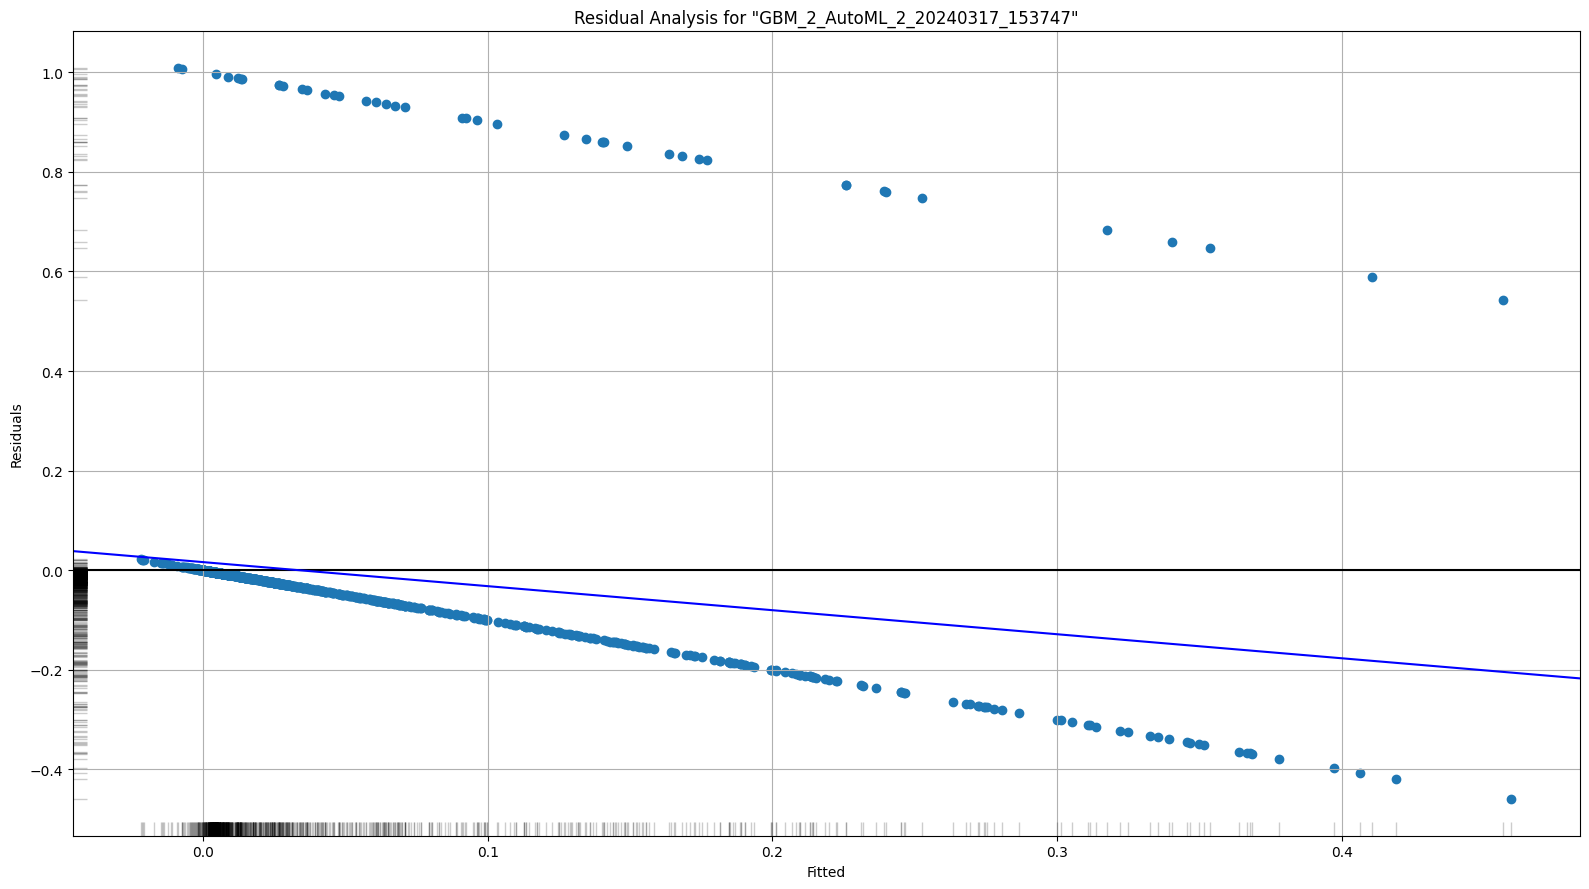

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

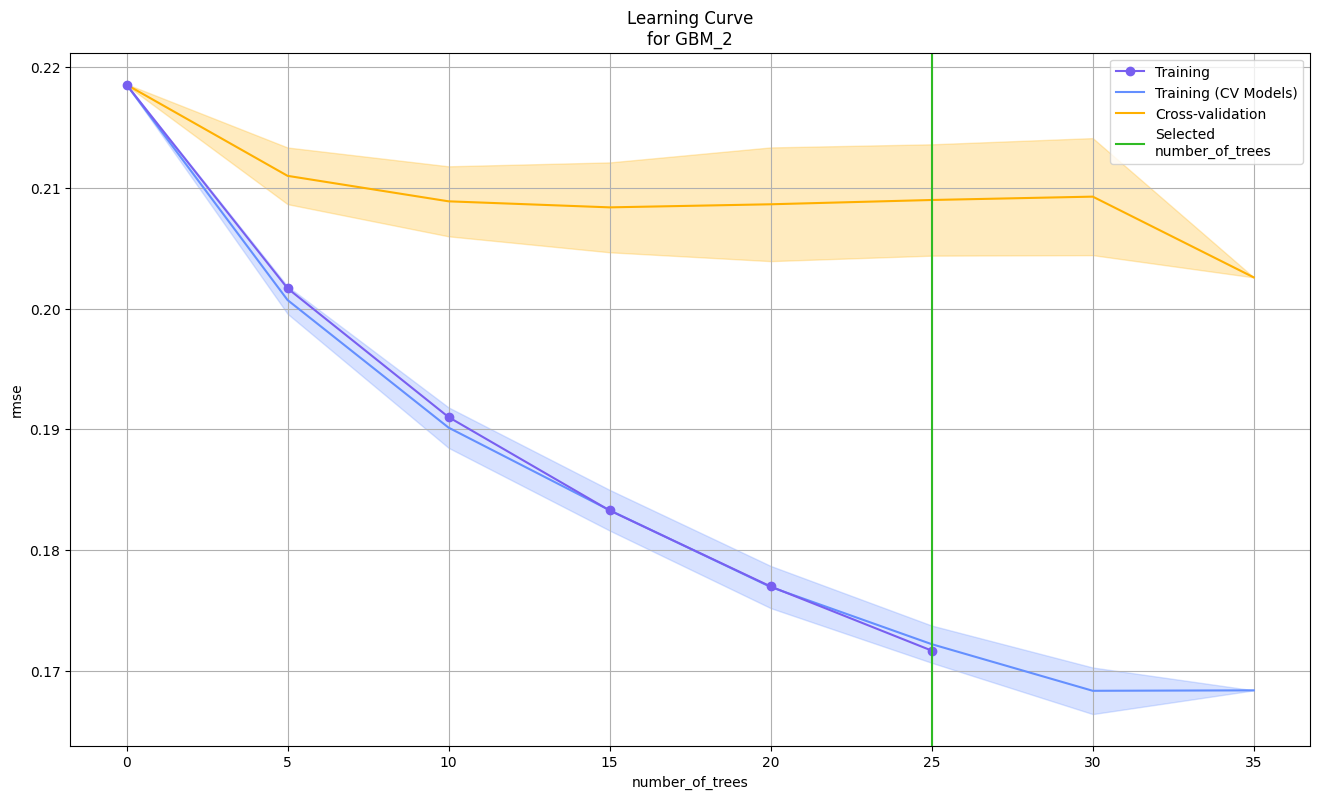

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

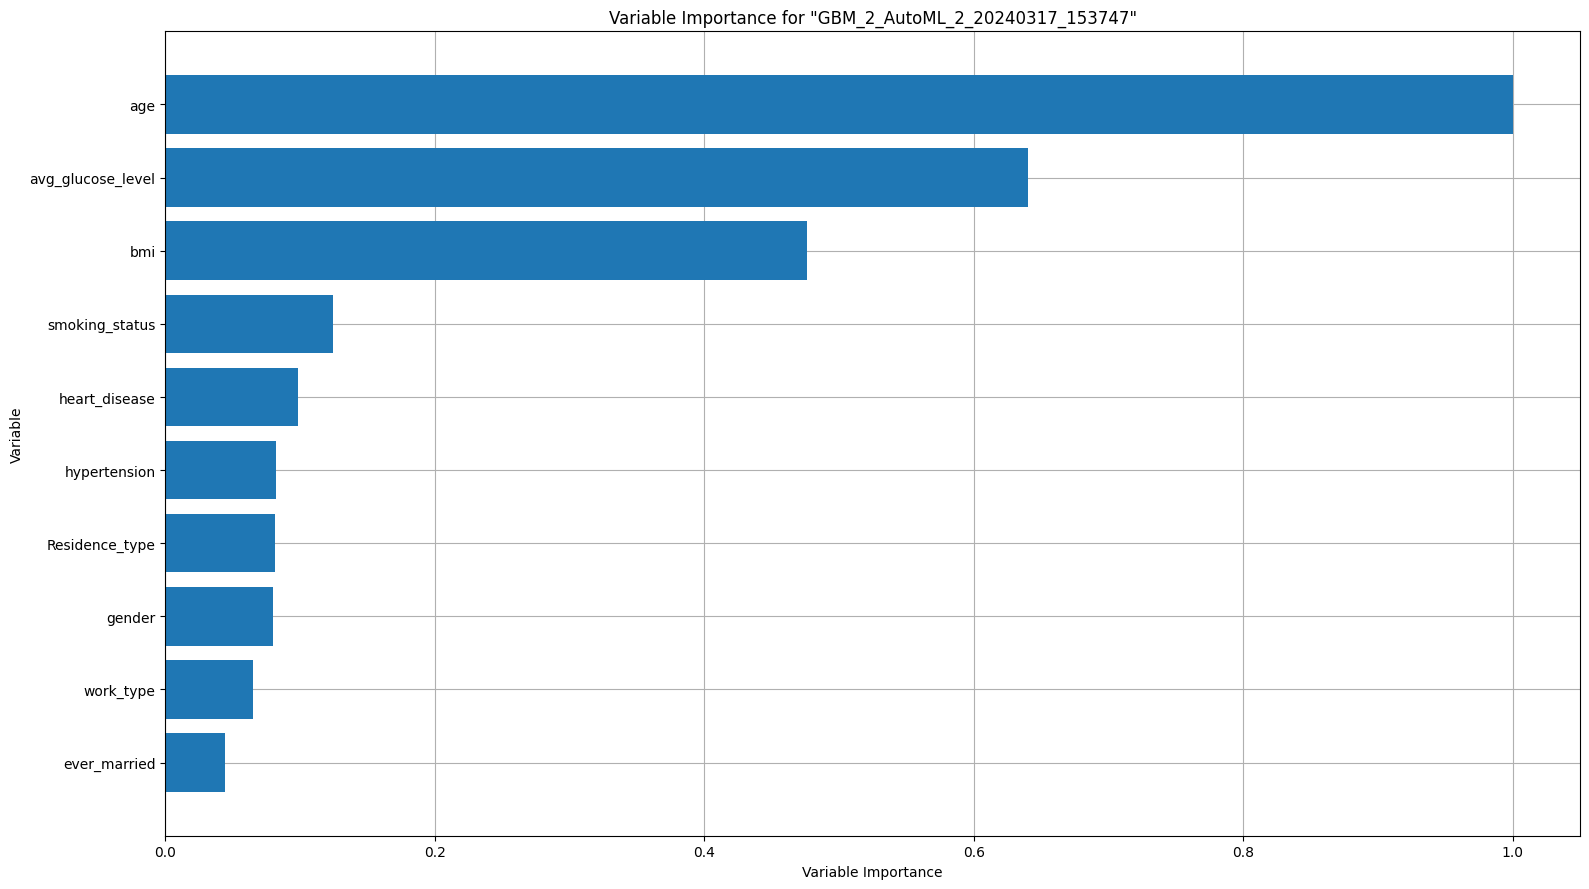

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

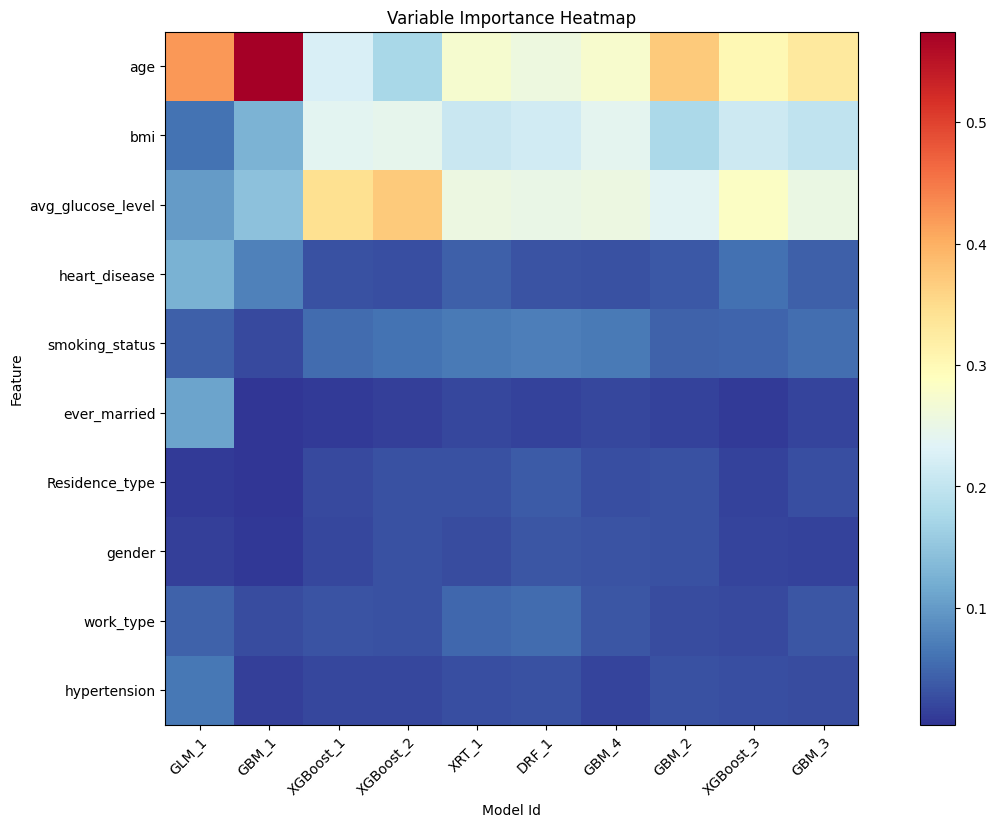

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

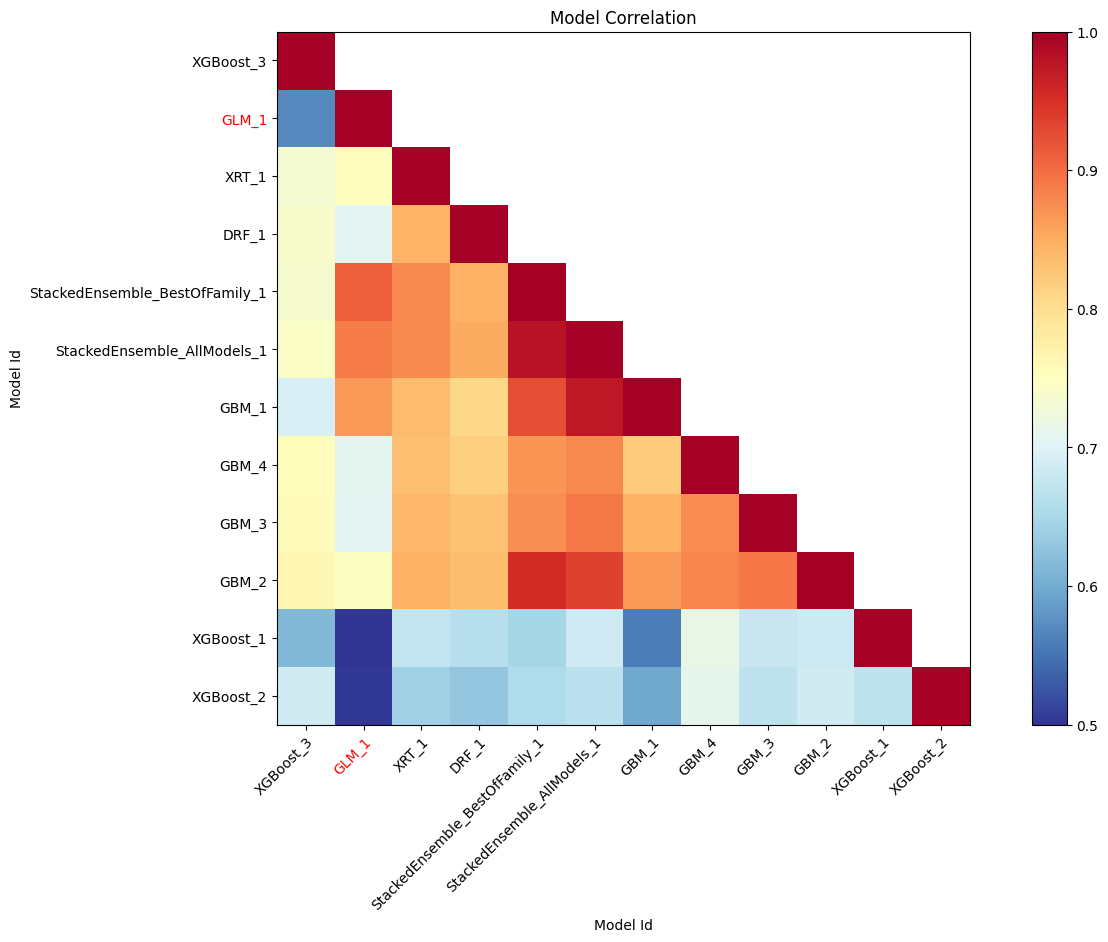

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

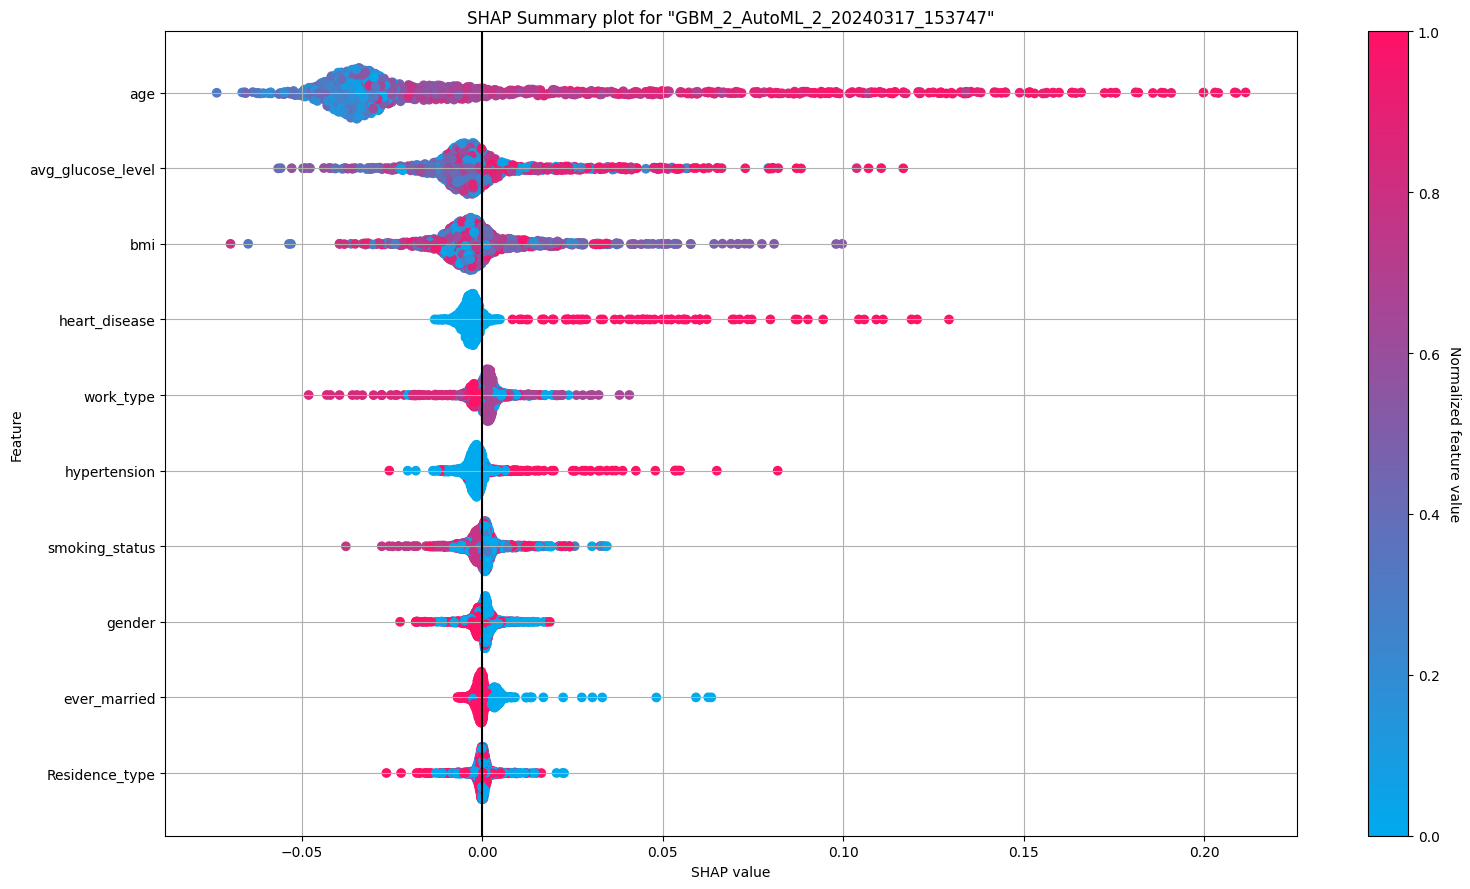

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

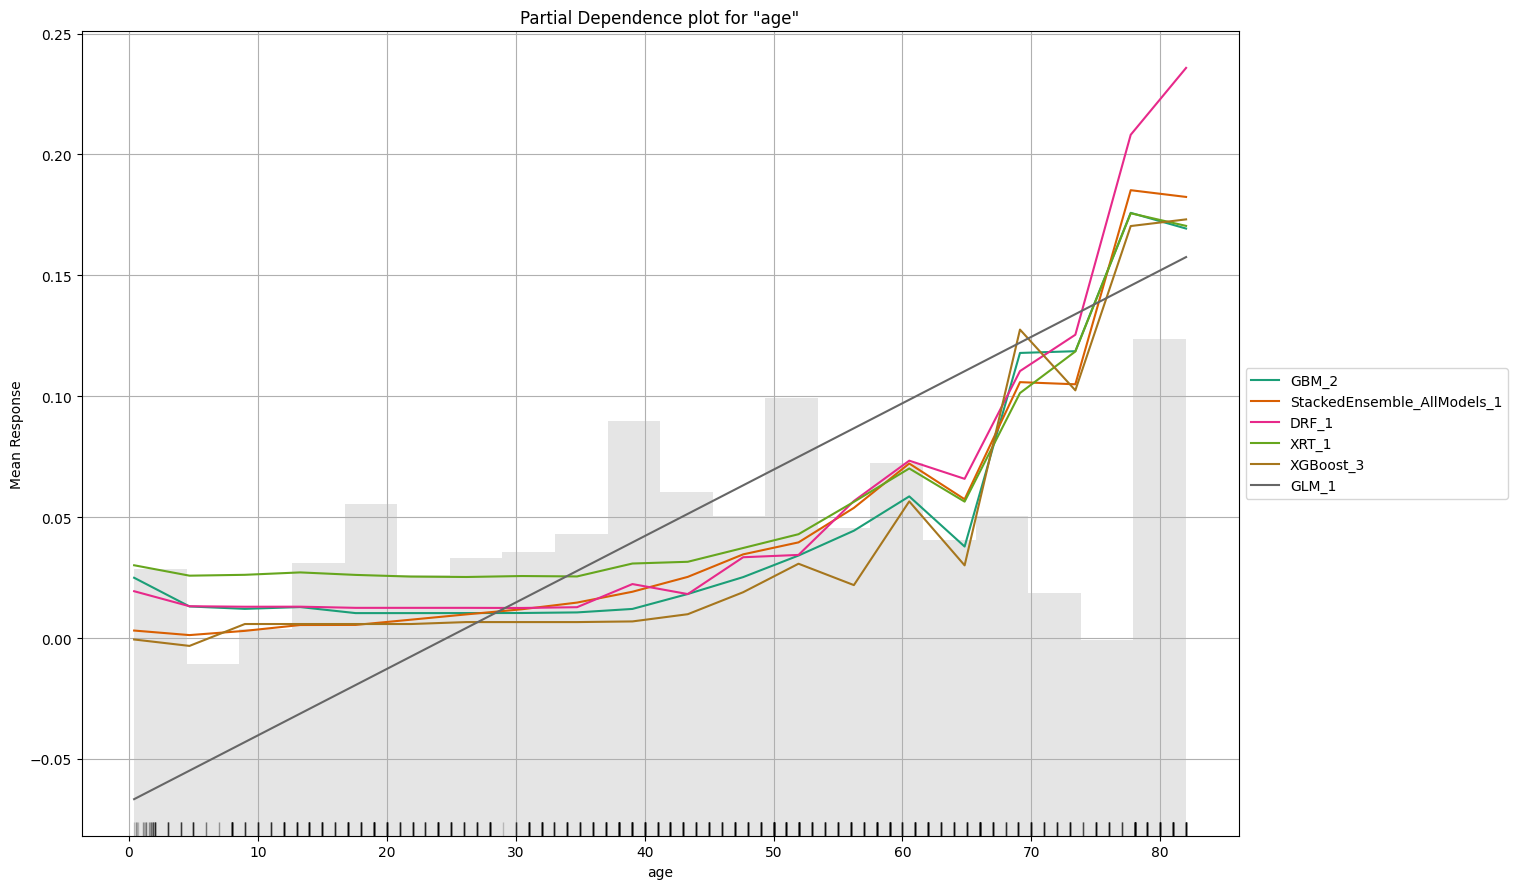

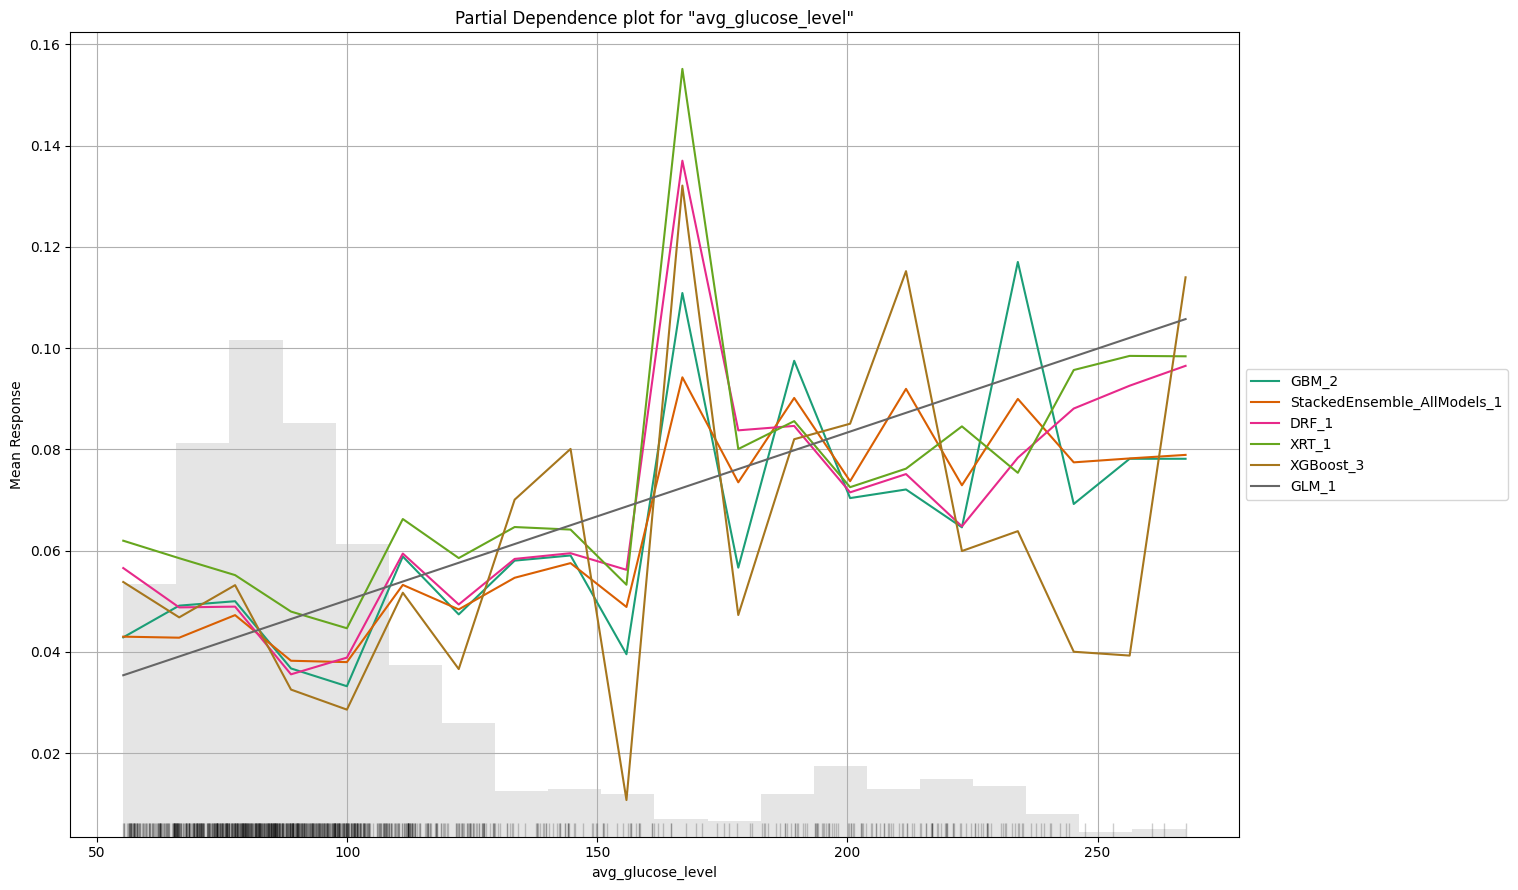

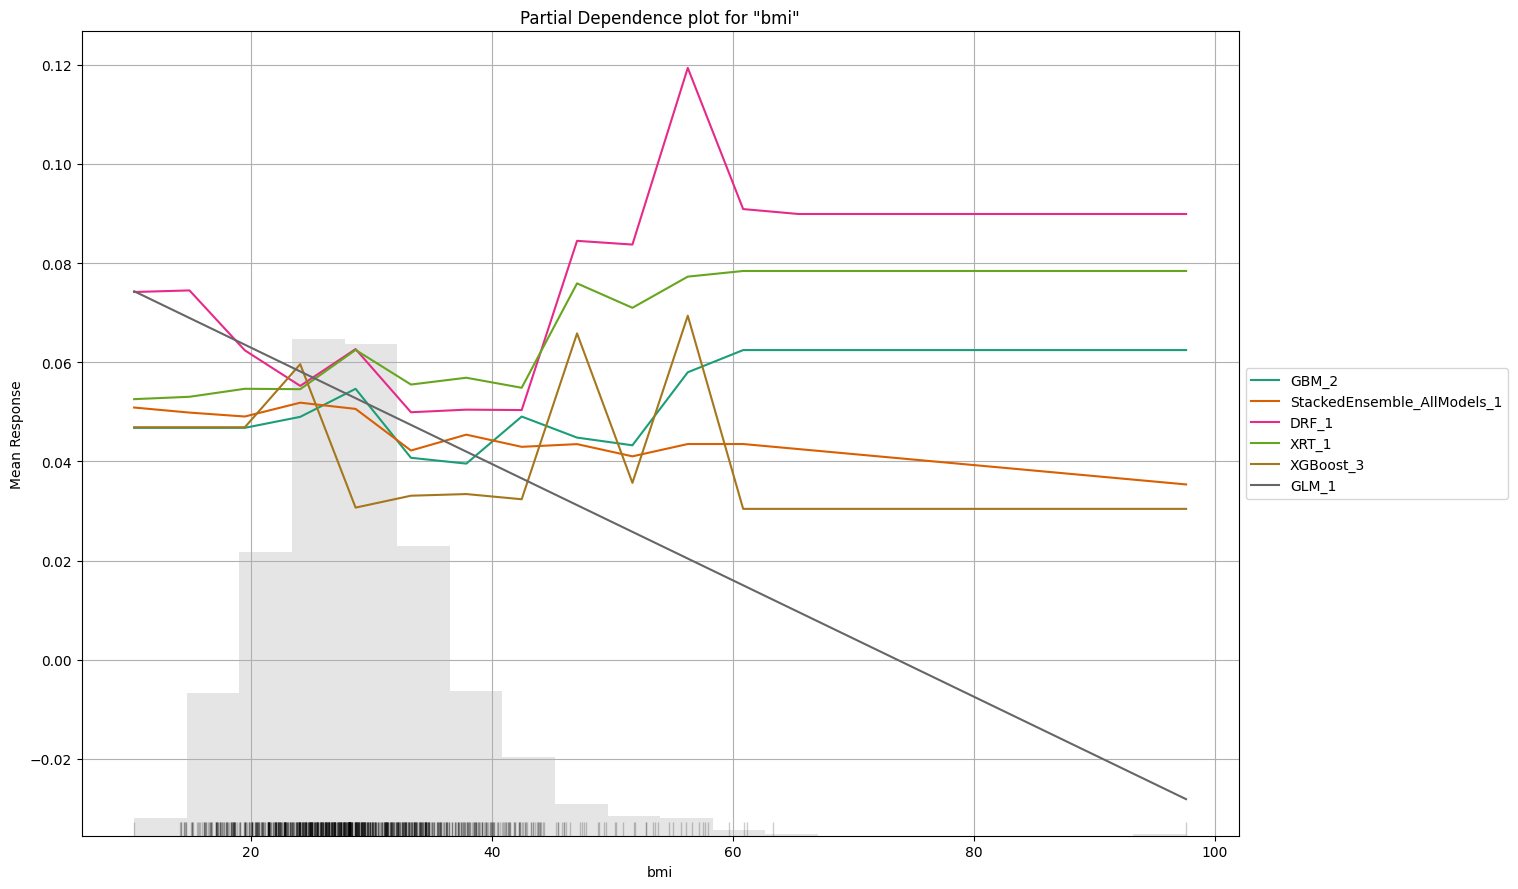

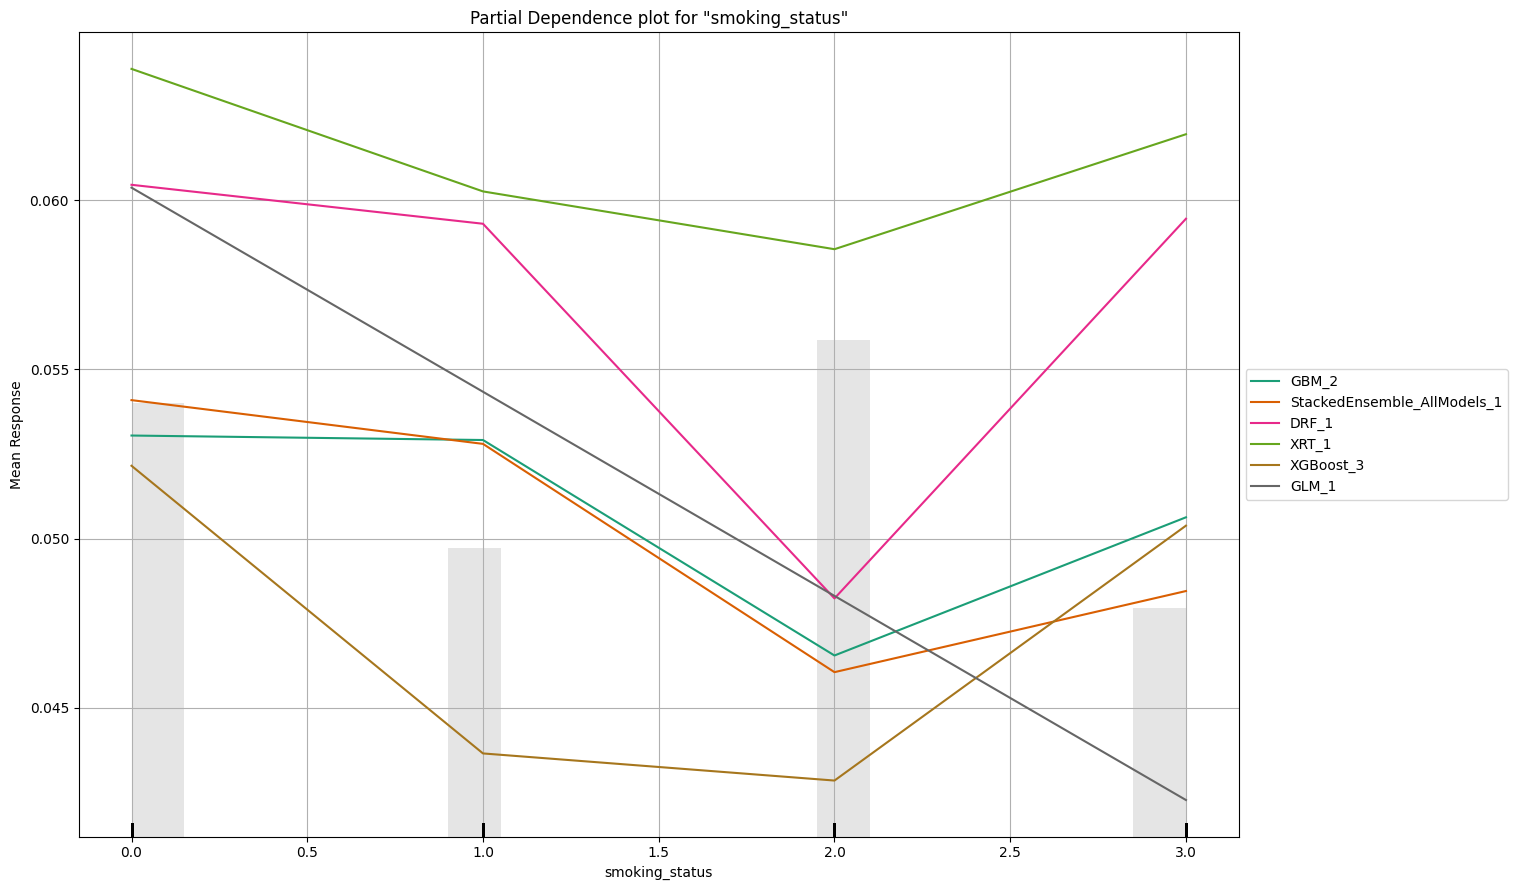

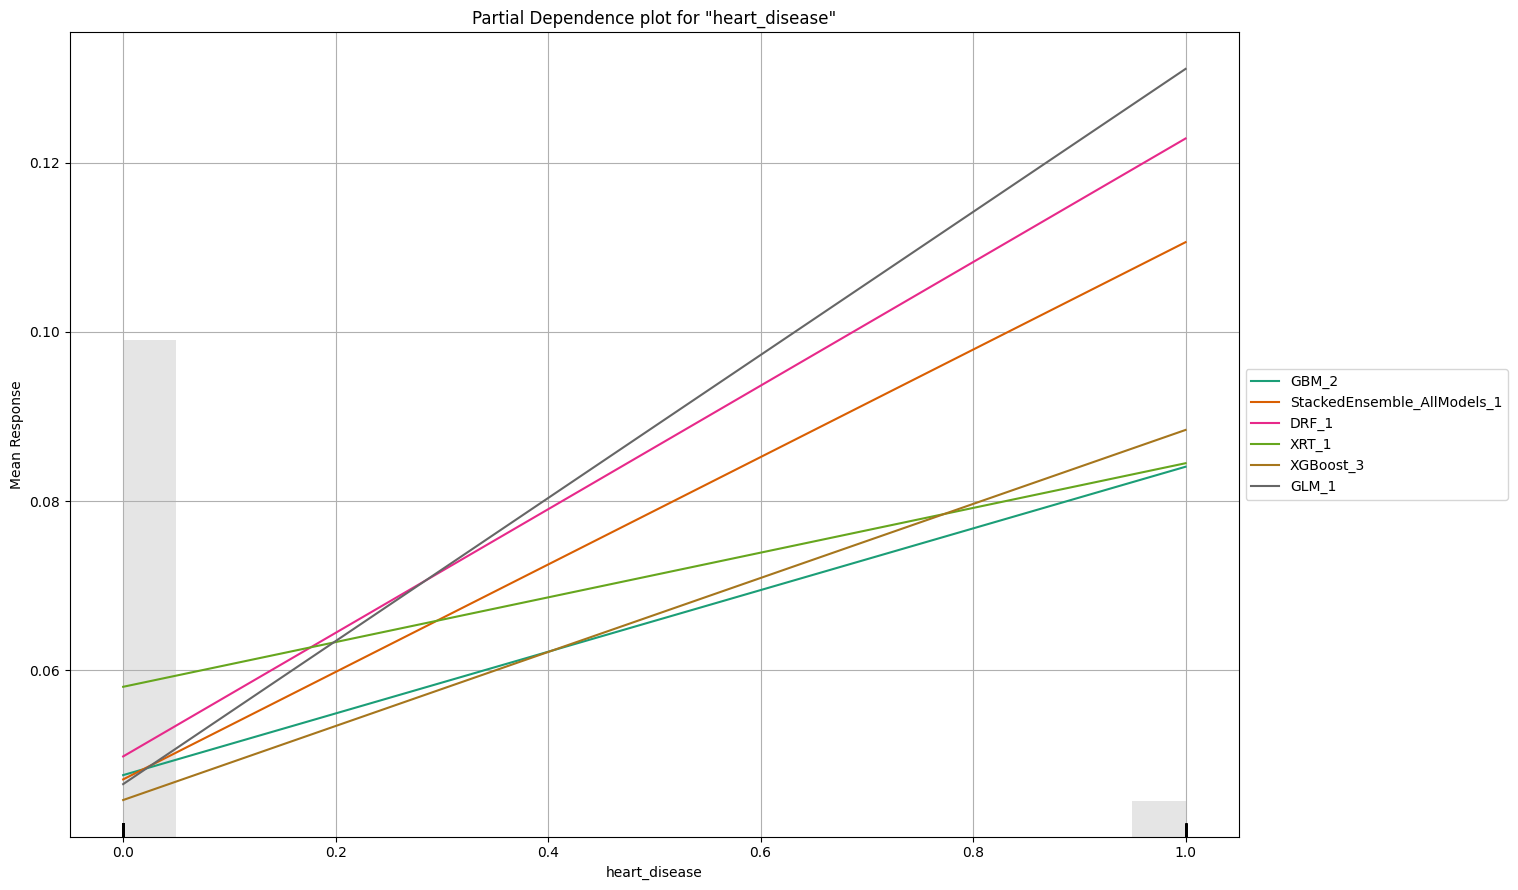

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

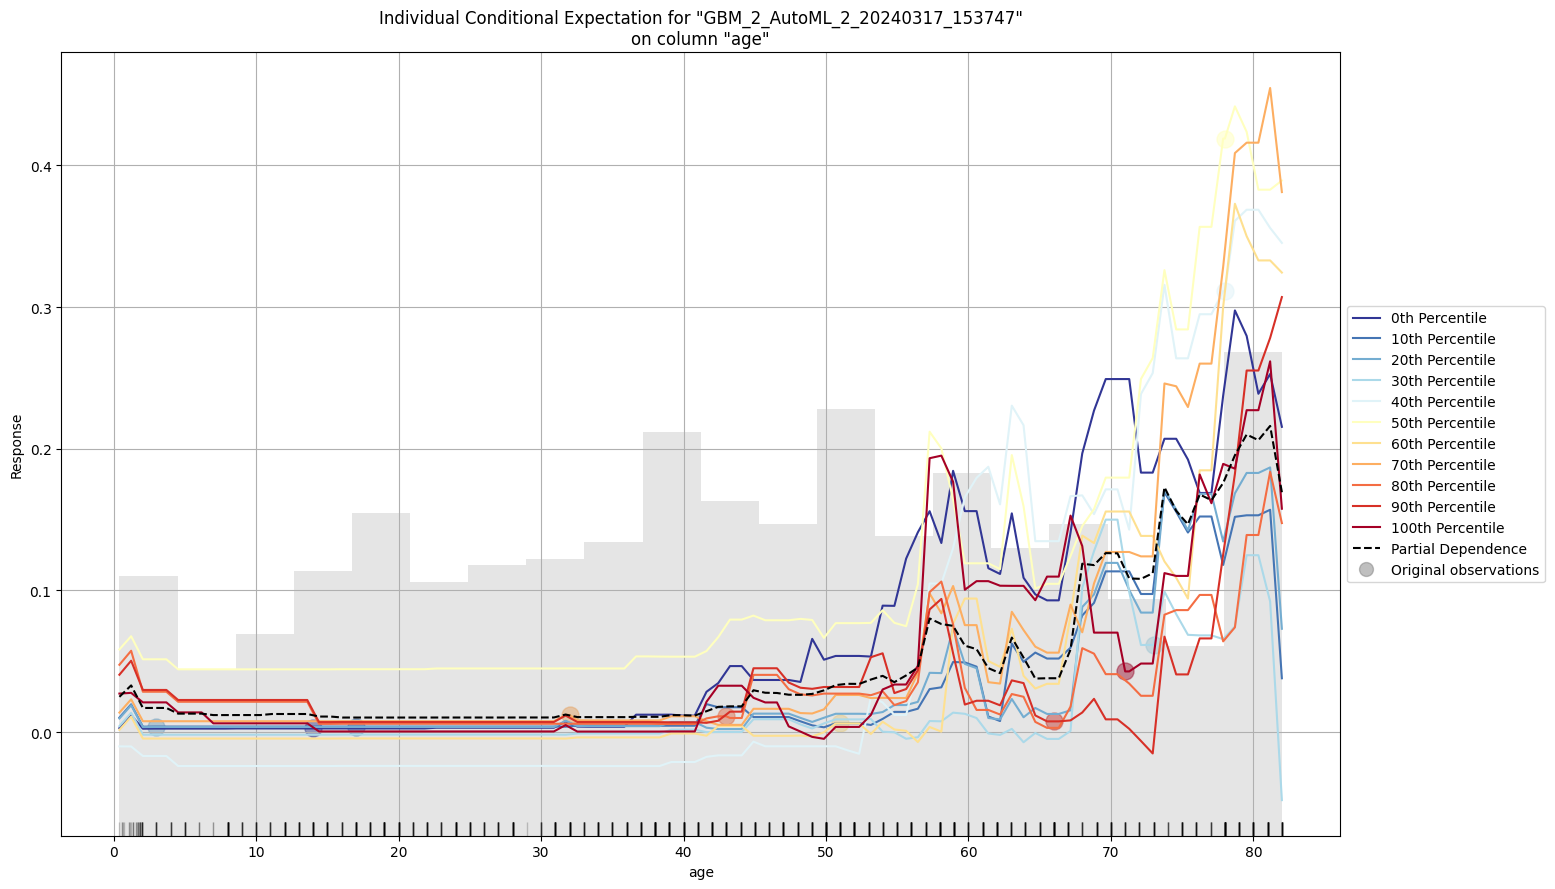

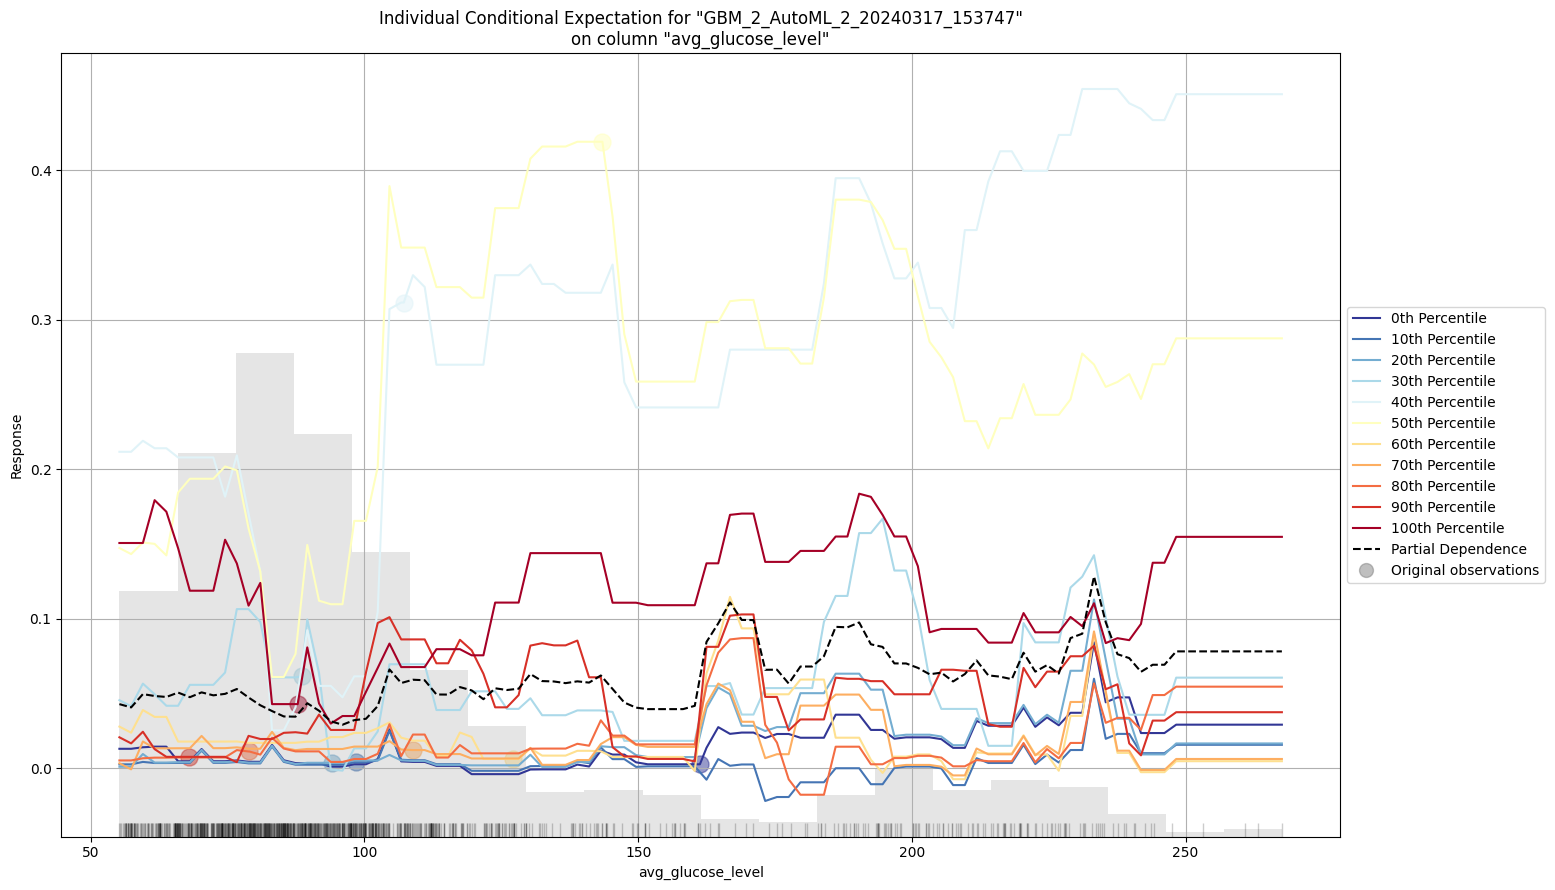

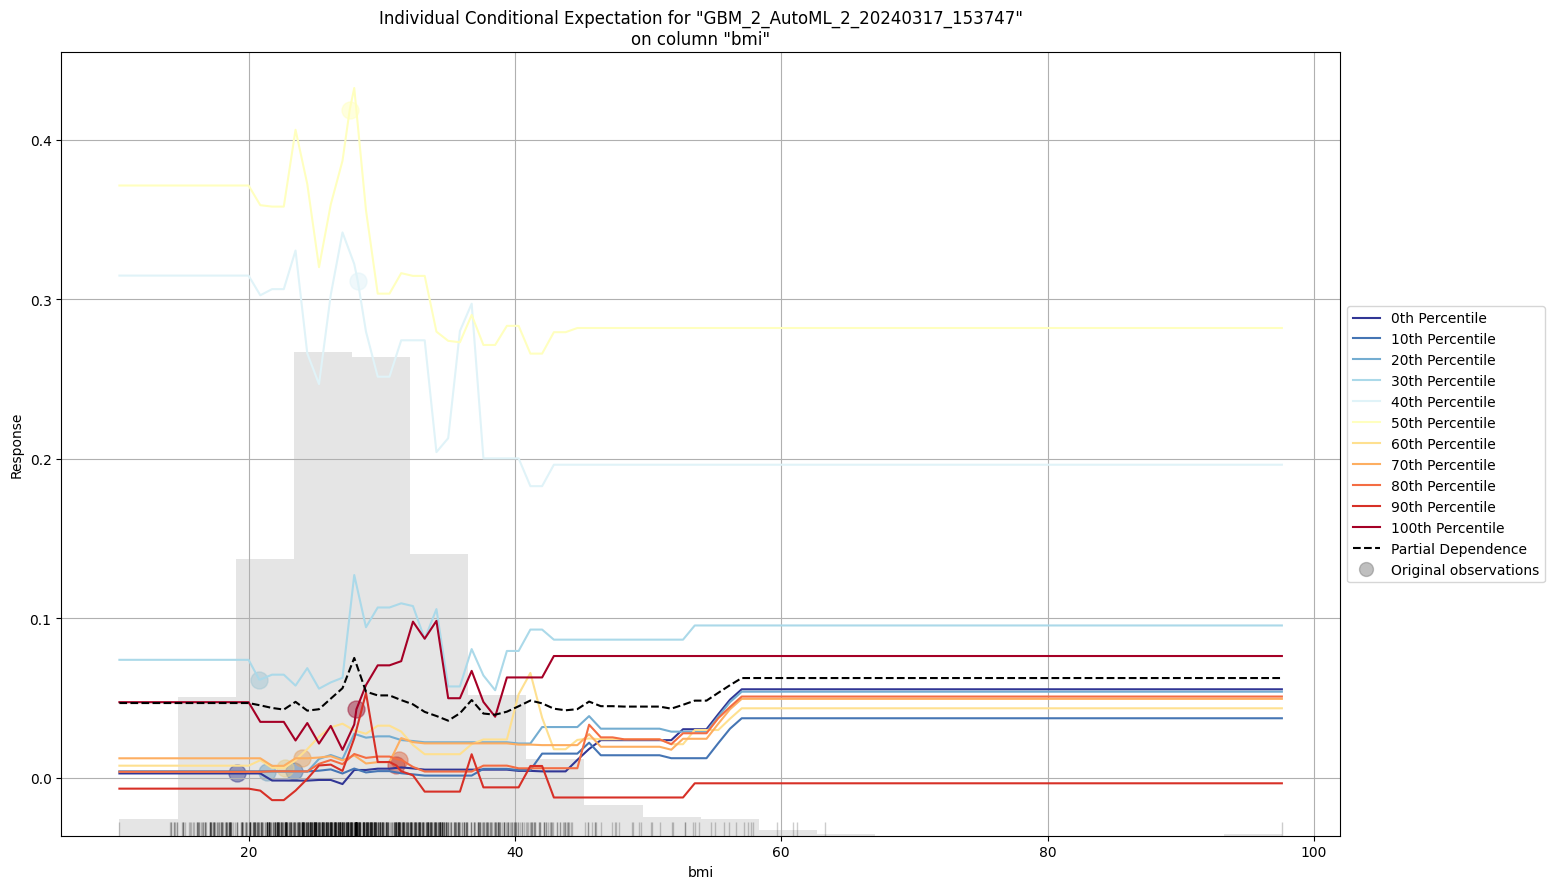

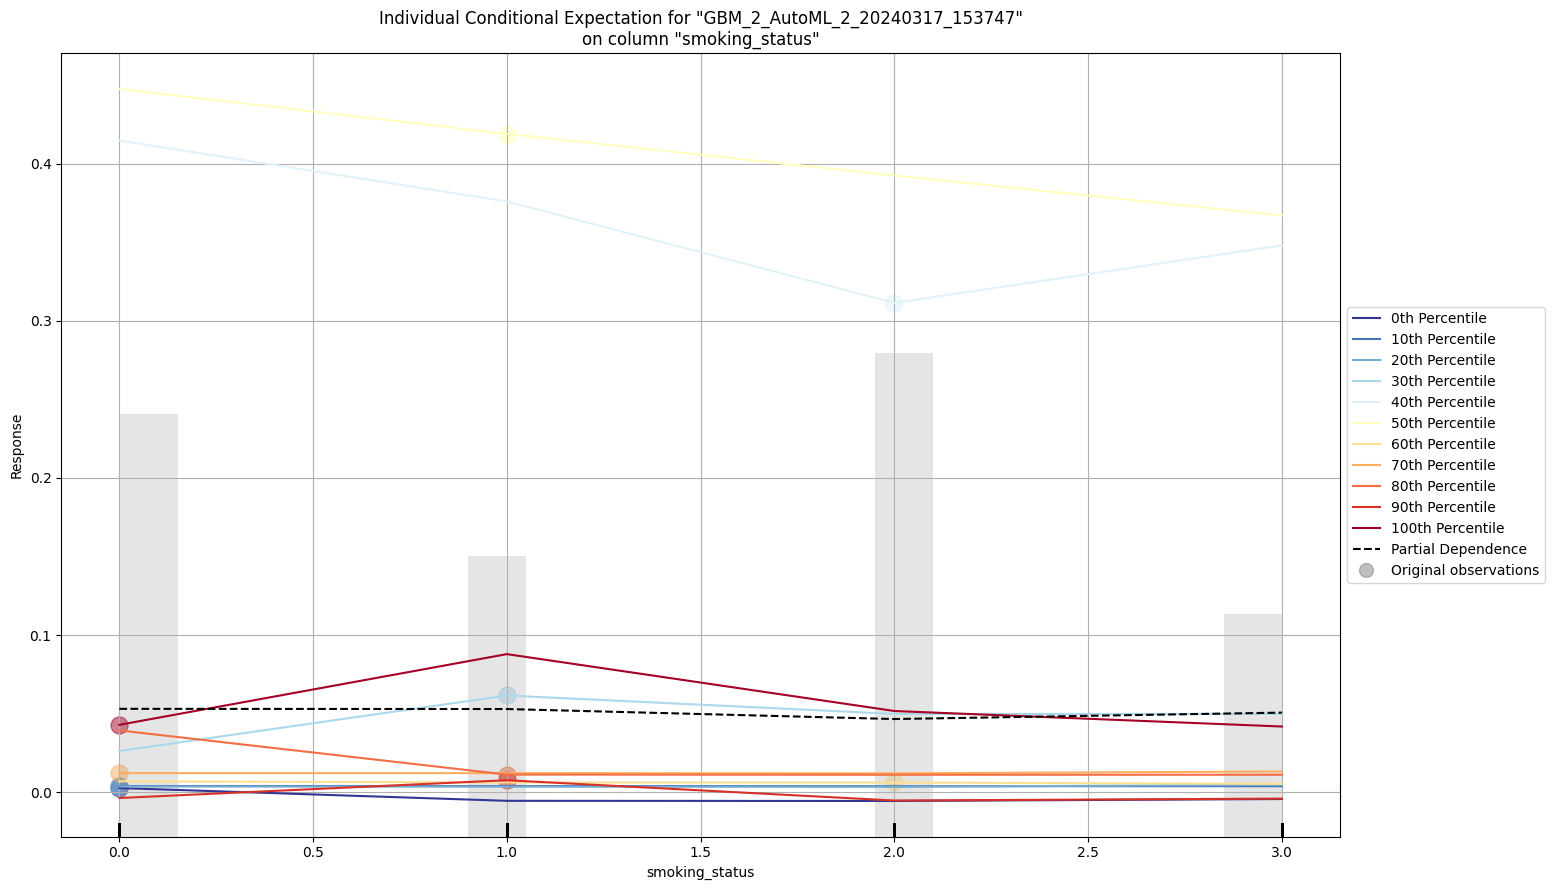

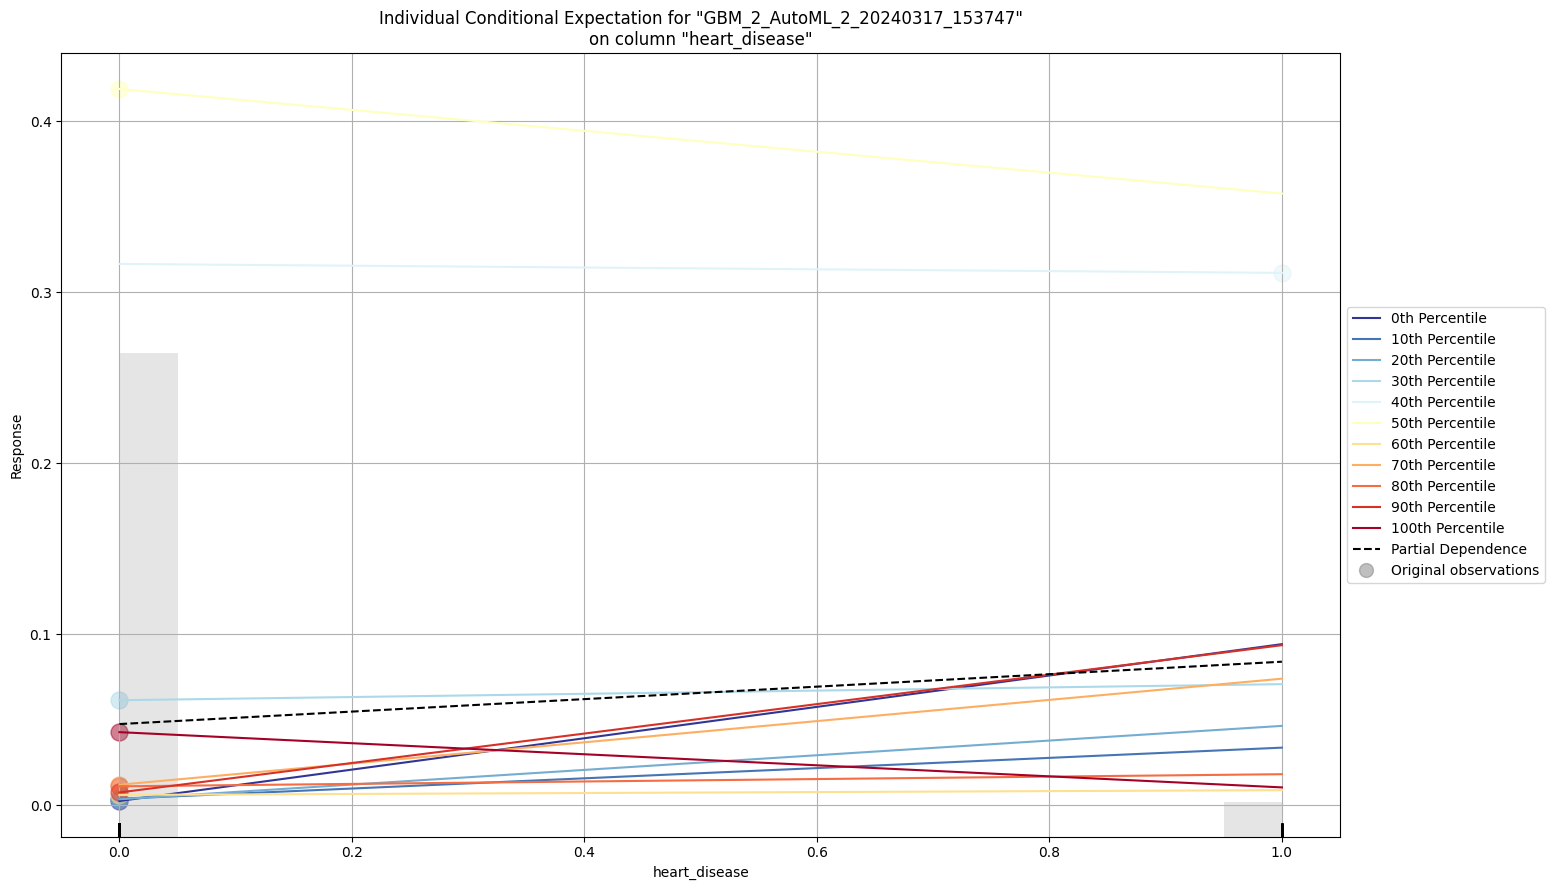

In [ ]:
explain_model = aml.explain(frame = df_test)

## CONCLUSION
- Linear Regression: The features 'age', 'ever_married', and 'bmi' appear to be the most important, with 'age' having the largest impact. The SHAP values indicate varying levels of impact across the values of each feature.

- XGBoost: Similar to the linear regression model, 'age', 'bmi', and 'avg_glucose_level' are significant, but there's a noticeable difference in the distribution of SHAP values. 'Age' and 'bmi' have a broad spread of SHAP values, suggesting a non-linear and complex relationship with the outcome.

- AutoML: The AutoML plot suggests a more even distribution of feature importance across many features, with 'age' still being prominent but less dominant. This model may be picking up more on the nuanced interactions between features.

Overall, 'age' is consistently important across all three models, suggesting it is a strong predictor of the outcome. The XGBoost and AutoML models, which likely capture non-linear relationships and interactions between features, show a broader spread of influence across additional features compared to the linear regression model.

### REFERENCES
- Geeks for Geeks: https://www.geeksforgeeks.org/understanding-logistic-regression/

- XGBoost Documentation: https://xgboost.readthedocs.io/en/stable/

- H2O Documentation: : https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html?_ga=2.129161676.1179250264.1708398551-1770022984.1708209167

- Towards Data Science(SHAP Analysis): https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

- SHAP Documentation: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

### LICENSE

MIT License

Copyright (c) 2024 pranitee23

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
